# Milestone 3

### Rob Lisy

Generate a clear statement problem and provide location for dataset.
Provide a clear solution to the problem for a non-technical audience. Your solution must include narrative in plain language explaining your results. 

Visually explore the data to generate insight and include summary statistics. For your visualization use multiple views of the data, which can include:
- scatter plots showing key relationships you have found in the dataset. Beware of over-plotting. 
- bar, box or violin plots for various categorical groups within the dataset. 
- Faceted plots to show diffences for different groups with in the data. 
- Other plot types you find useful; heatmaps, histograms, etc. 
- All plots should use methods that will aid in viewer perception. 

----

#### Additional Steps:

In Milestone 1 I did lots of code (I'll note the transition point below). I've got to add the following additional steps for Milestone 2:

- Identify a likely distribution for several of the features
- Compute basic summary statistics by both classical, bootstrap, and Bayesian methods;
- Compute confidence intervals for the above summary statistics by classical, bootstrap, and Bayesian methods;
- Leverage confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant.


----------
Problem statement:
    A young family moving to King county would like to know how housing features contribute to the price of different houses. This may help them focus their search on houses within their price range.
    
Data sets: 
    Housing price data for King County - https://www.kaggle.com/harlfoxem/housesalesprediction
    Neighborhood boundaries and labels - https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods%40public/information/

In [1]:
from os import path
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import scipy
import statsmodels.stats.api as sms

# Pretty printing
%precision %.2f
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rcParams["figure.figsize"] = (20,10)

housing_data = f"kc_house_data.csv"


def download_if_not_exists(URL: str, filename: str):
    """
    Helper function to download the file at the URL if it doesn't already exist
    :param URL: A string with the URL location
    :param filename: The file name on disk
    """
    if path.exists(f"{filename}"):
        return
    else:
        req = requests.get(URL)
        url_content = req.content
        csv_file = open(f"{filename}", 'wb')
        csv_file.write(url_content)
        csv_file.close()
    return

# Download our source data if we don't have it locally...
download_if_not_exists("https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv",
                      housing_data)
# This is the Zillow shape files for neighborhoods.
#download_if_not_exists("https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods@public/download/?format=shp&refine.state=WA&refine.county=King&timezone=America/Los_Angeles",
#                      neighborhoods)

#unzip the shape file from Zillow
#with ZipFile(neighborhoods, 'r') as zip: 
#    zip.extractall()

# import the CSVs as a data set
housing = pd.read_csv(housing_data, header=0)
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00000,3,1.00000,1180,5650,1.00000,0,0,...,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,20141209T000000,538000.00000,3,2.25000,2570,7242,2.00000,0,0,...,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,20150225T000000,180000.00000,2,1.00000,770,10000,1.00000,0,0,...,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,20141209T000000,604000.00000,4,3.00000,1960,5000,1.00000,0,0,...,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,20150218T000000,510000.00000,3,2.00000,1680,8080,1.00000,0,0,...,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503


In [2]:
# see what the column types are, and clean them up
housing.dtypes

cat_cols = ['waterfront', 'view','condition','zipcode', 'grade']
for c in cat_cols:
    housing[c] = housing[c].astype('category')

housing['date'] = pd.to_datetime(housing['date'], errors='coerce')

In [3]:
housing.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront             category
view                   category
condition              category
grade                  category
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                category
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [4]:
# Let's describe the summary statistics
# Housing data is always SUPER skewed... we're going to generate some custom percentiles for the .describe()
housing.describe(percentiles=[x/10 for x in range(1,10)]+[.95, .99, .995])

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000,21613.00000
mean,4580301520.86499,540088.14177,3.37084,2.11476,2079.89974,15106.96757,1.49431,1788.39069,291.50905,1971.00514,84.40226,47.56005,-122.21390,1986.55249,12768.45565
std,2876565571.31206,367127.19648,0.93006,0.77016,918.44090,41420.51152,0.53999,828.09098,442.57504,29.37341,401.67924,0.13856,0.14083,685.39130,27304.17963
min,1000102.00000,75000.00000,0.00000,0.00000,290.00000,520.00000,1.00000,290.00000,0.00000,1900.00000,0.00000,47.15590,-122.51900,399.00000,651.00000
10%,1036000346.00000,245000.00000,2.00000,1.00000,1090.00000,3322.20000,1.00000,970.00000,0.00000,1926.00000,0.00000,47.35030,-122.37200,1256.00000,3666.60000
20%,1774000252.00000,298470.00000,3.00000,1.50000,1320.00000,4644.00000,1.00000,1120.00000,0.00000,1947.00000,0.00000,47.43224,-122.34600,1420.00000,4800.00000
30%,2517000630.00000,345000.00000,3.00000,1.75000,1520.00000,5612.00000,1.00000,1260.00000,0.00000,1956.00000,0.00000,47.49690,-122.31200,1550.00000,5625.60000
40%,3278601732.00000,399500.00000,3.00000,2.00000,1710.00000,6744.00000,1.00000,1400.00000,0.00000,1965.00000,0.00000,47.53960,-122.28700,1690.00000,6750.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,1560.00000,0.00000,1975.00000,0.00000,47.57180,-122.23000,1840.00000,7620.00000
60%,5307500252.00000,519000.00000,4.00000,2.50000,2130.00000,8520.20000,2.00000,1760.00000,0.00000,1983.00000,0.00000,47.62110,-122.18900,2020.00000,8382.00000


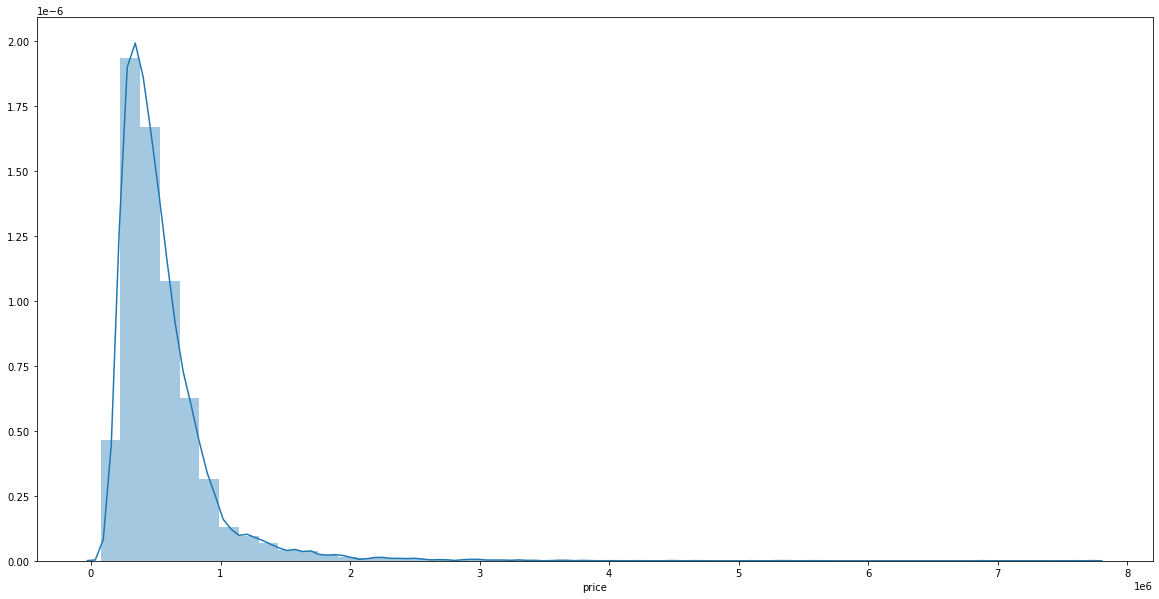

In [5]:
# Graph the price
sns.distplot(housing['price']);

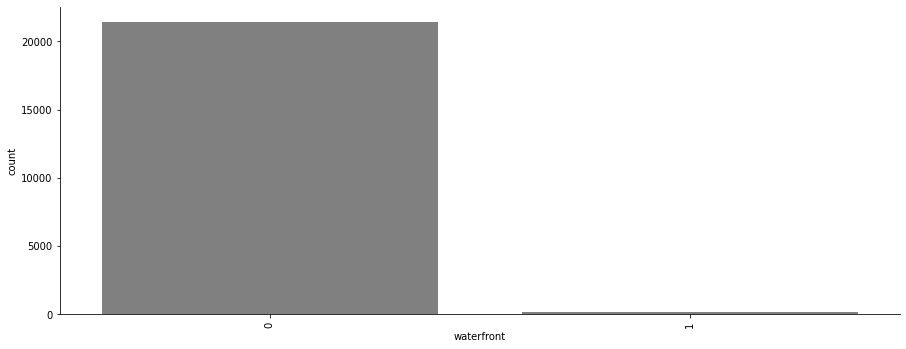

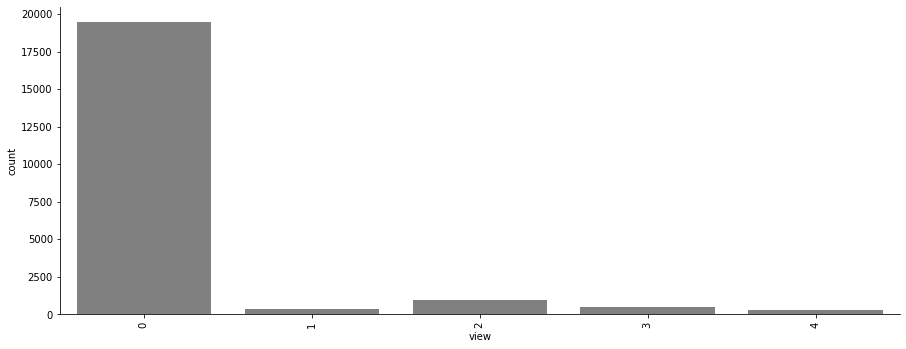

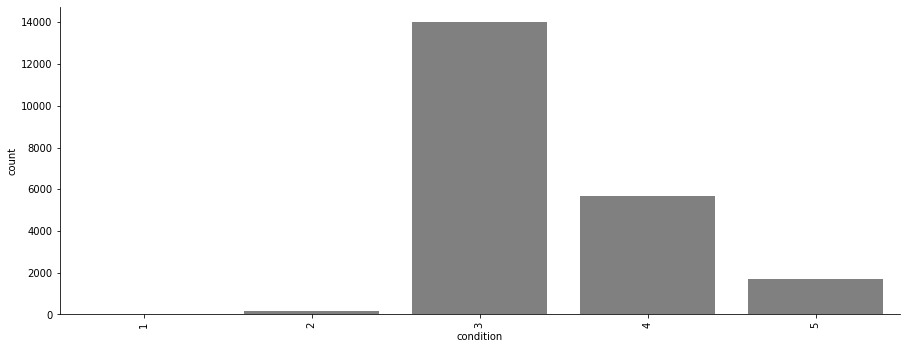

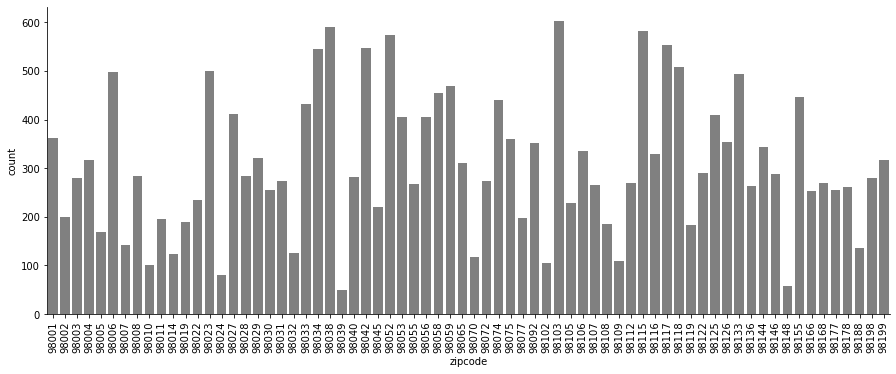

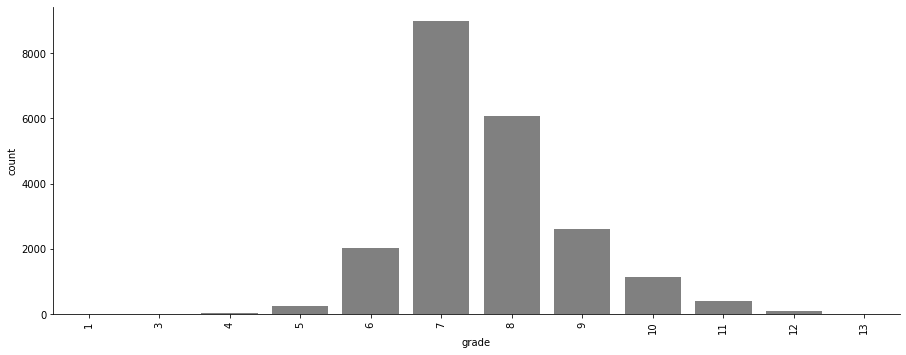

In [6]:
# Plot some densities using bar graphs
cat_cols = ['waterfront', 'view', 'condition', 'zipcode', 'grade']

for c in cat_cols:
    g = sns.catplot(x = c, data = housing, kind = 'count', color = 'grey', aspect = 2.5);
    g.set_xticklabels(rotation = 90);
    plt.show()

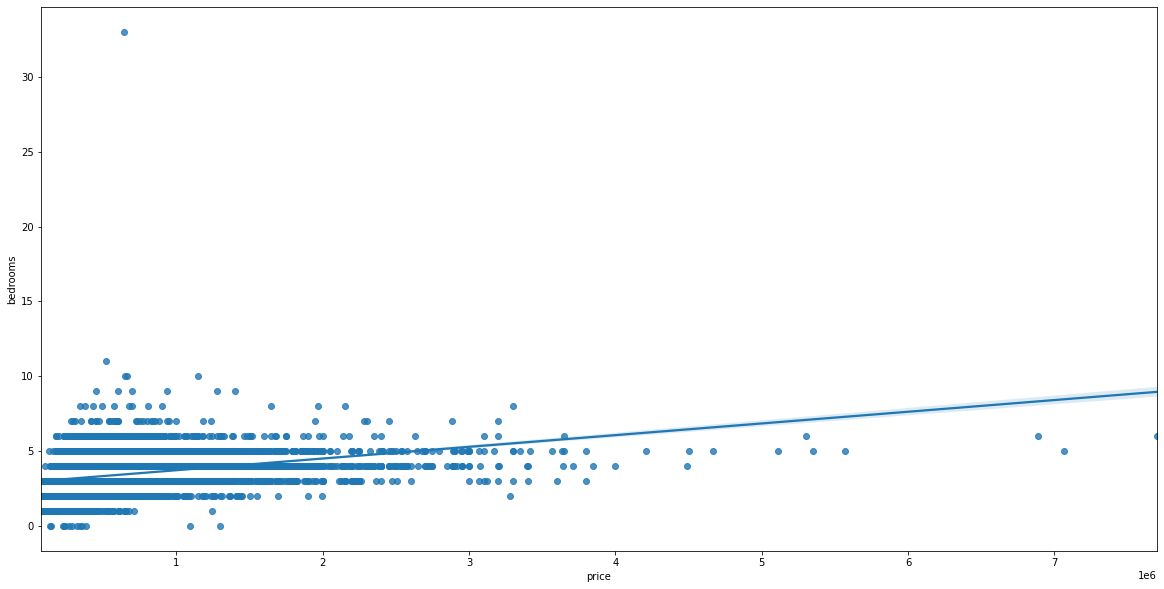

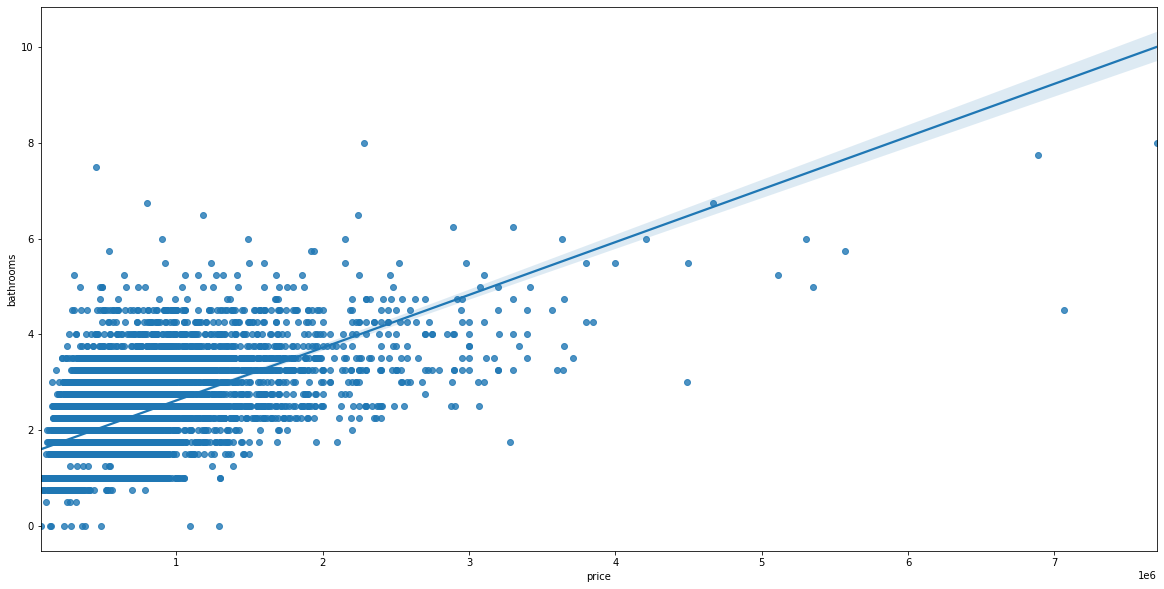

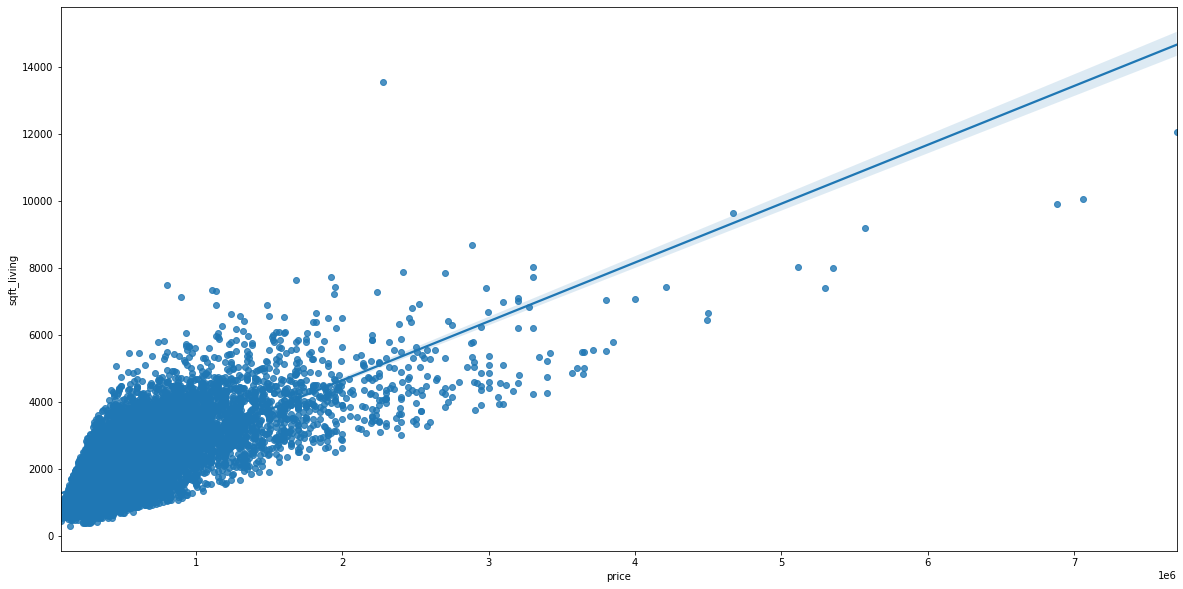

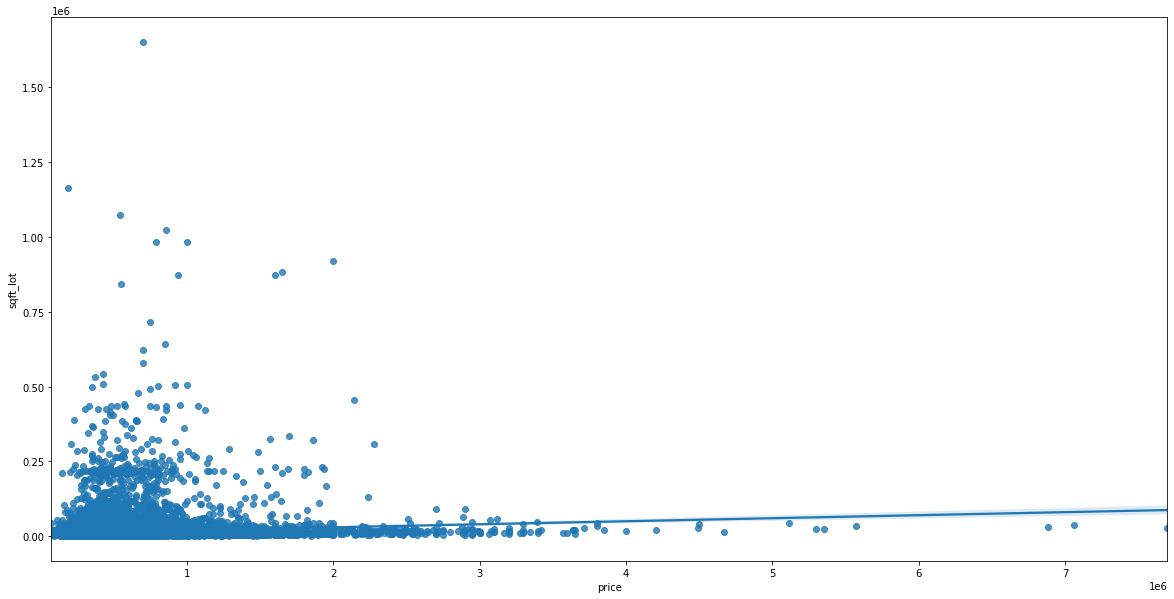

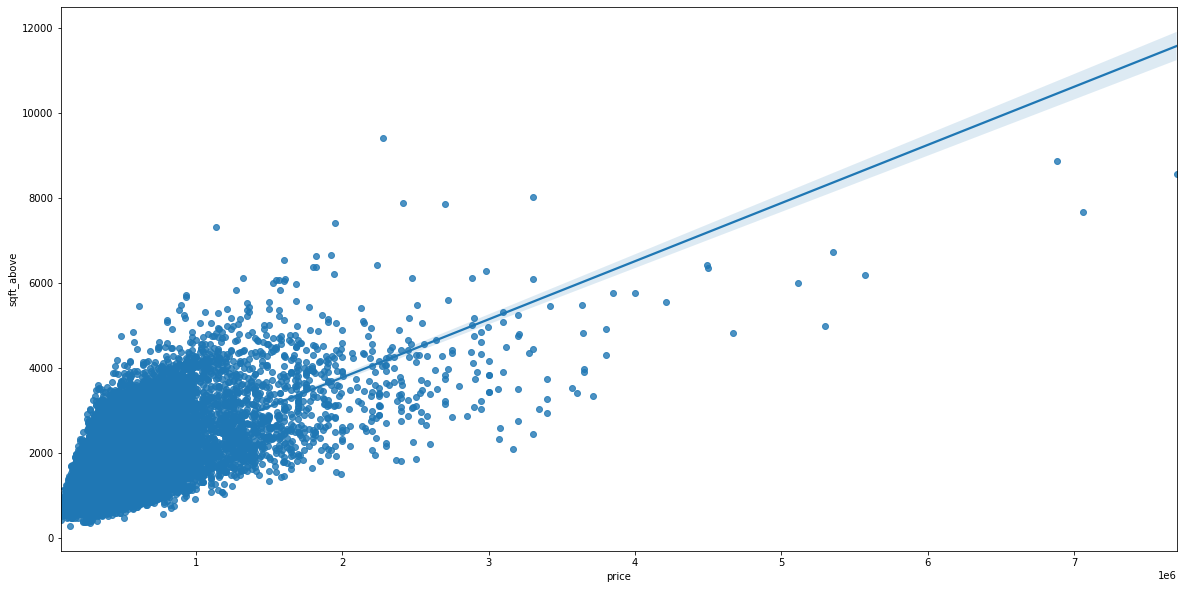

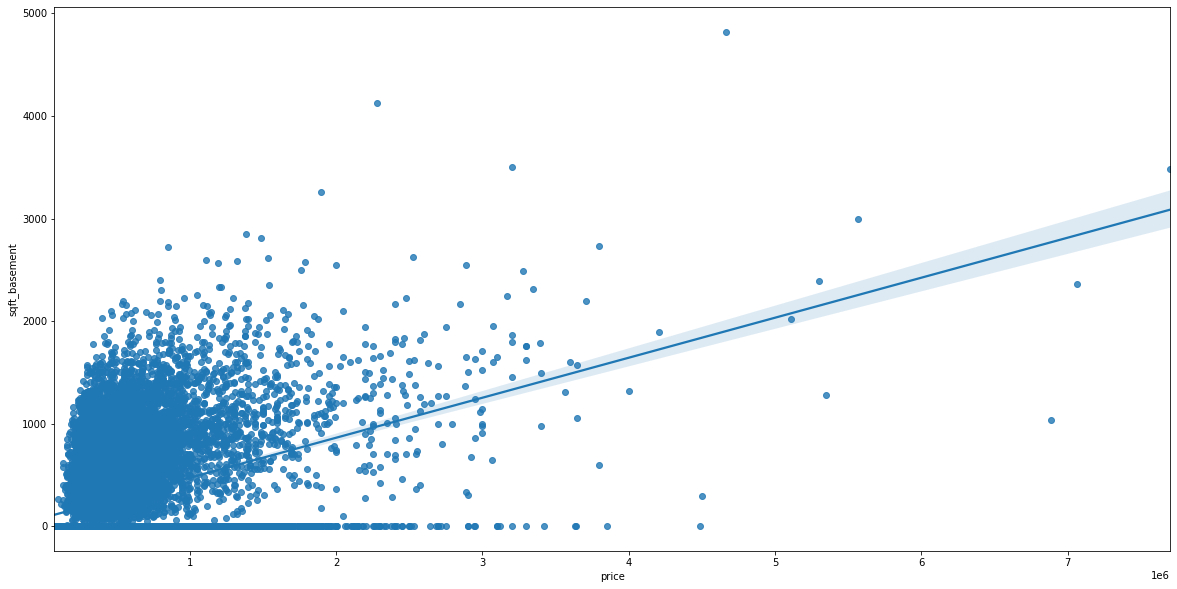

In [7]:
# This is going to be a regression model, since price is continuous. Let's plot relationships between some variables and price.
price_rel_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in price_rel_cols:
    sns.regplot(housing['price'], housing[c])
    plt.show();

# Looks like we can skip being super concerned with `sqft_lot`

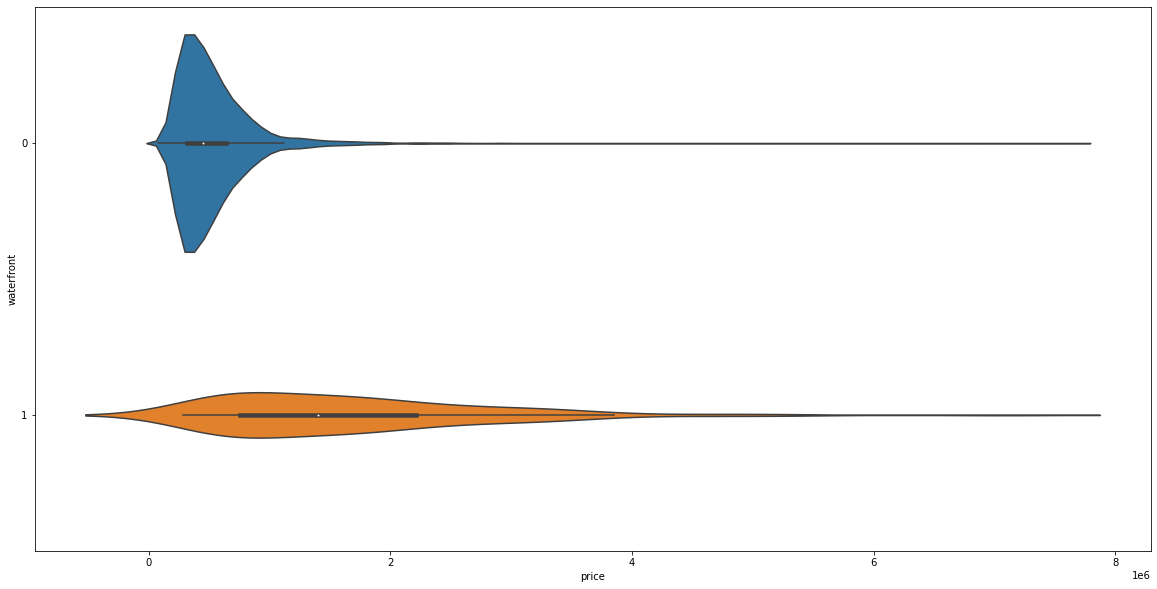

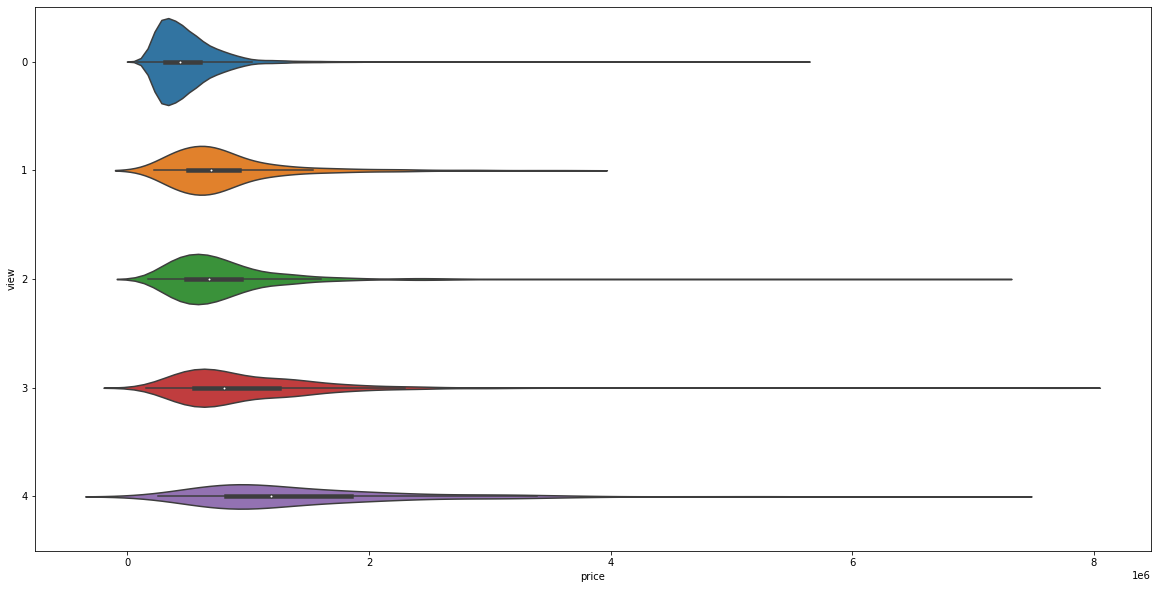

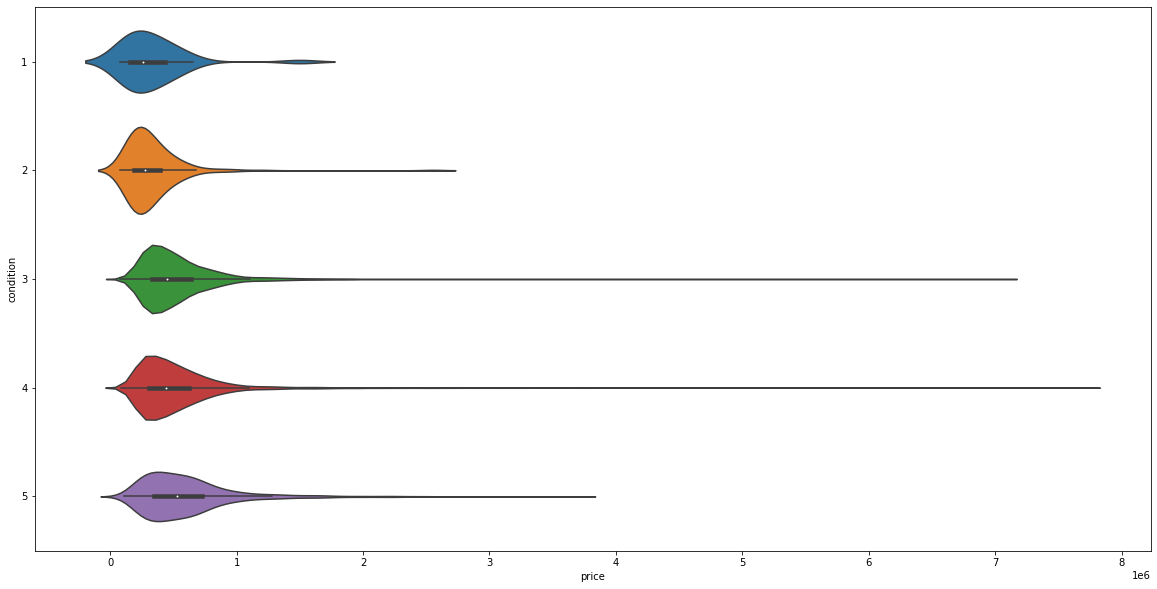

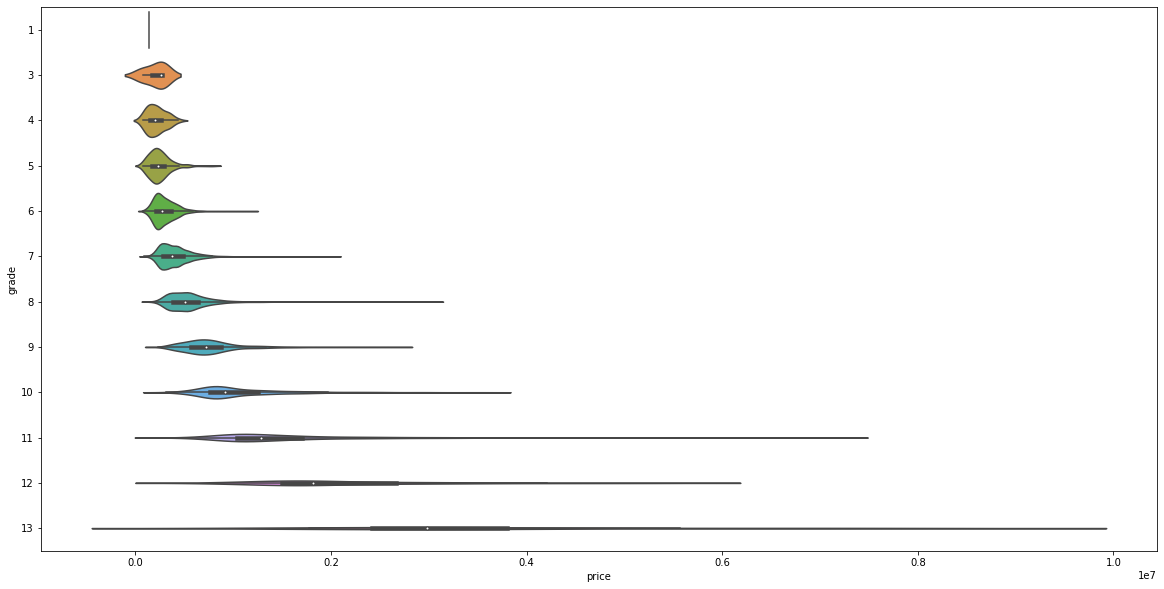

In [8]:
# for the categorical columns, make distribution plots
cat_cols = ['waterfront', 'view', 'condition', 'grade']
for c in cat_cols:
    sns.violinplot(x=housing['price'], y=housing[c])
    plt.show();

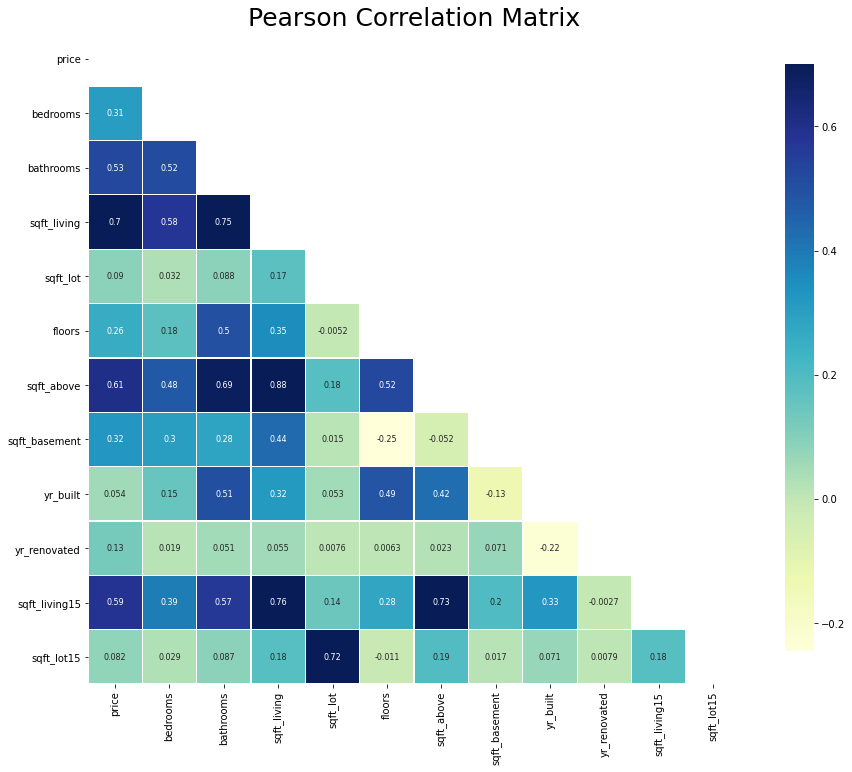

In [9]:
# Let's make a heat map for the correlations
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'sqft_living15','sqft_lot15']

# Remove columns without correlation OR boolean values
mask = np.zeros_like(housing[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix', fontsize=25)

sns.heatmap(housing[features].corr(), linewidths=0.25, vmax=0.7, square=True, cmap="YlGnBu",
            linecolor='w', annot=True, annot_kws={"size":8}, mask=mask, cbar_kws={"shrink": .9});

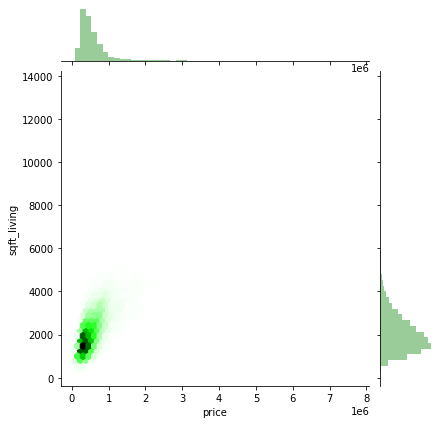

In [10]:
# Hexbin between price and square footage
sns.jointplot(x = 'price', y = 'sqft_living', data = housing, kind = 'hex', color = 'green');

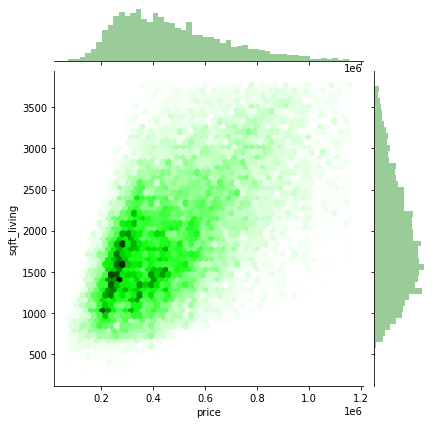

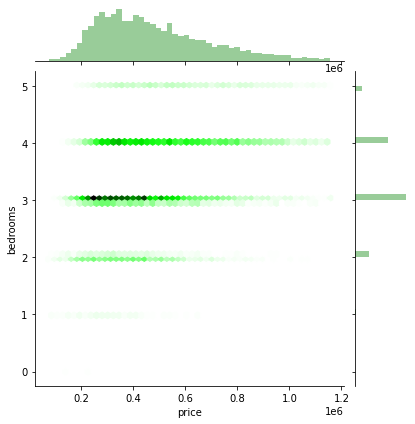

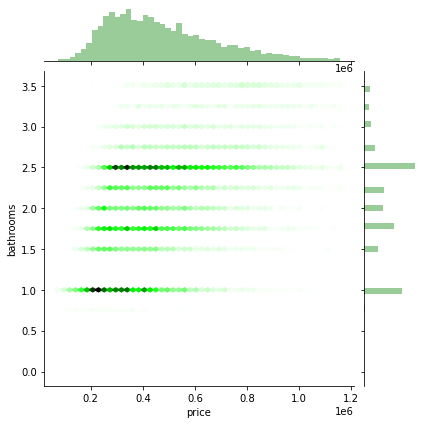

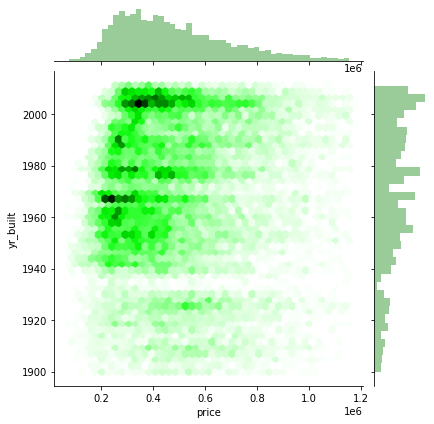

In [11]:
# Looks like this is highly sensitive to outliers (14,000 sq ft house? $7.7m sale price?)
# Let's limit the plot axis so that we're not only seeing those values
# these limits are at the 95% levels, per the .describe() above.
c_price = housing['price'] <= 1156480

cols_conditions = [['sqft_living', (housing['sqft_living'] <= 3760)],
                   ['bedrooms', (housing['bedrooms'] <= 5)],
                   ['bathrooms', (housing['bathrooms'] <= 3.5)],
                   ['yr_built', (housing['yr_built'] <= 2011)]
                  ]
# for every column and filter combo, make a pretty hex bin graph
for c in cols_conditions:
    plot_data = housing[c[1] & c_price]
    sns.jointplot(x = 'price', y = c[0], data = plot_data, kind = 'hex', color = 'green');

# Summary

Our couple who is looking to find a home would do well to keep the total square footage of the property in mind. 

If they want to be conscious of their budget, they should look for: 
- something built in the late 1960s (vs a bunch of the newer houses post 2000 that are higher in price)
- there's lots of variation (and therefore choice) in houses with 2.5 bathrooms
- they'll probably look for a 3 bedroom house

----
## Milestone 2

The below work is added for Milestone 2


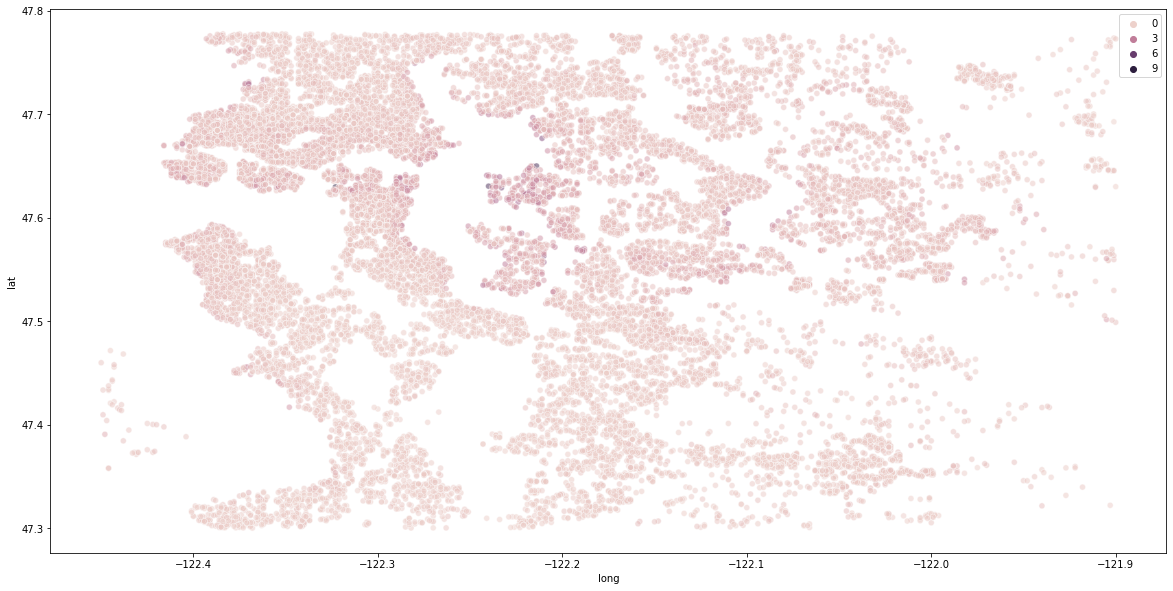

In [16]:
# Let's make a "map"
# kind of silly, but we can show the neighborhood effect

# there's a bunch of stuff in like Woodenville... not showing it for this viz
is_east = housing['long'] <= -121.9
is_west = housing['long'] >= -122.45
is_south = housing['lat'] >= 47.3
housing_zoom = housing[is_east & is_west & is_south]

# hue=tips.time.tolist()

sns.scatterplot(x = housing_zoom['long'], y = housing_zoom['lat'], 
               hue = housing_zoom['price'].tolist(),
               alpha = .5);

## Location, location, location.
You can pretty clearly see the neighborhoods and geography of Seattle:
- Belleview, Mercer Island, Capitol Hill all have some high prices.
- There are no homes sold in the ocean, SeaTac airport, the industrial south, or the core of the city.

For simplicity sake, I didn't plot Vashon Island (mostly), or the stuff that's pretty far east of Settle metro.

In [17]:
housing.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront             category
view                   category
condition              category
grade                  category
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                category
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

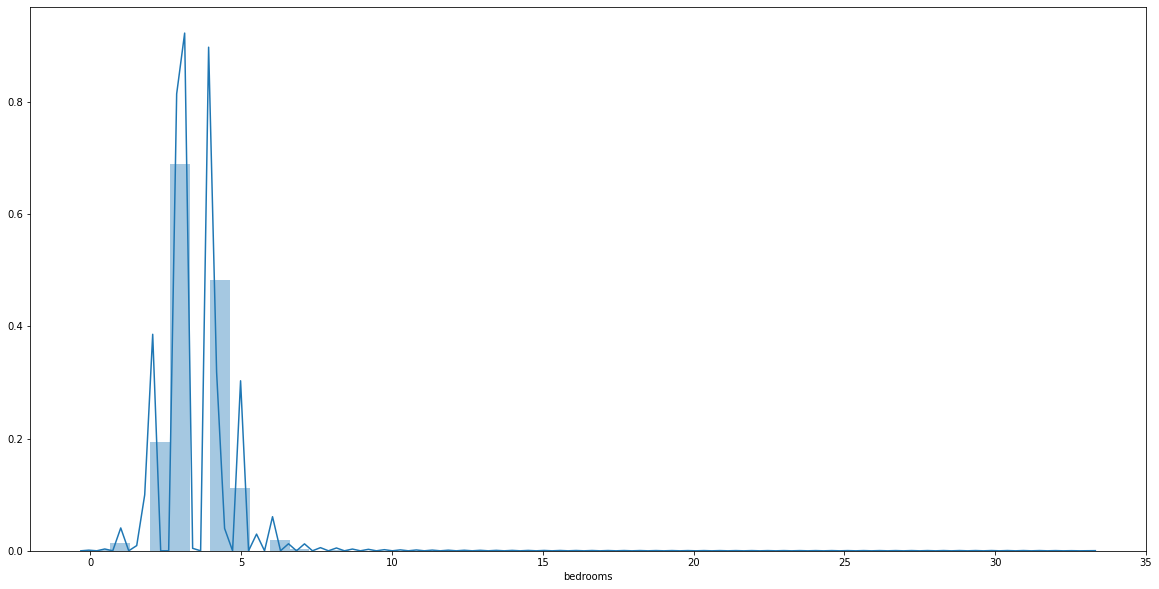

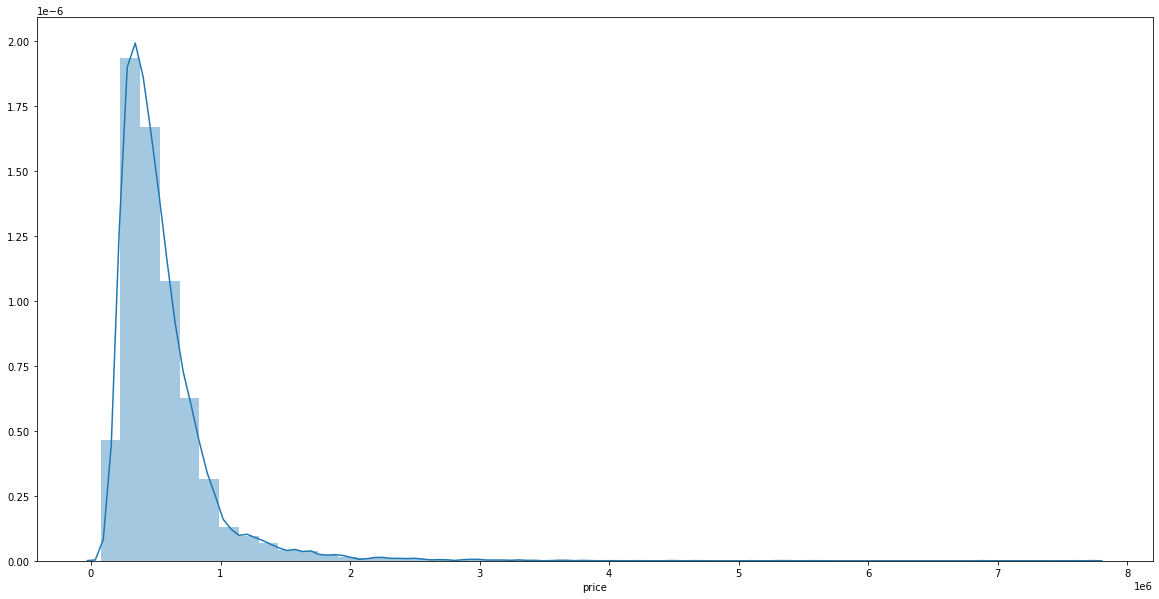

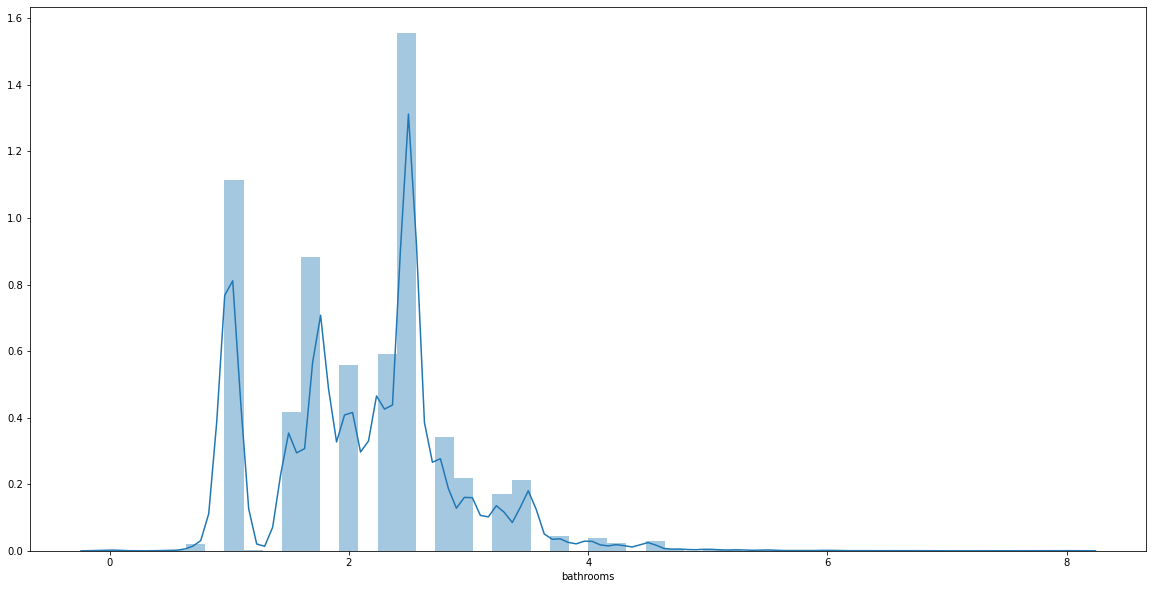

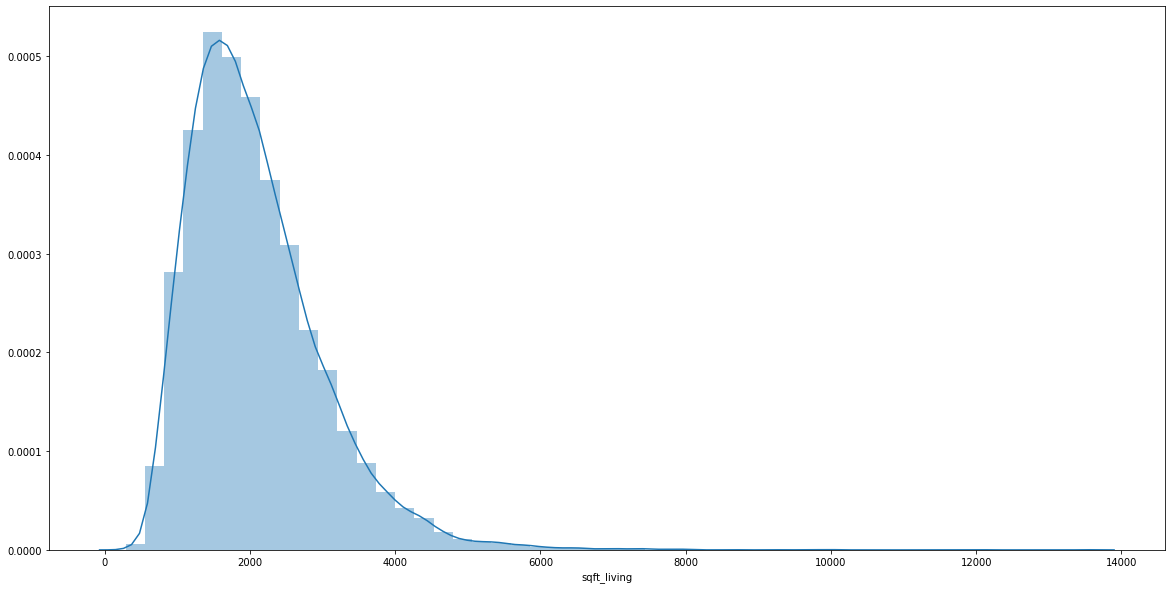

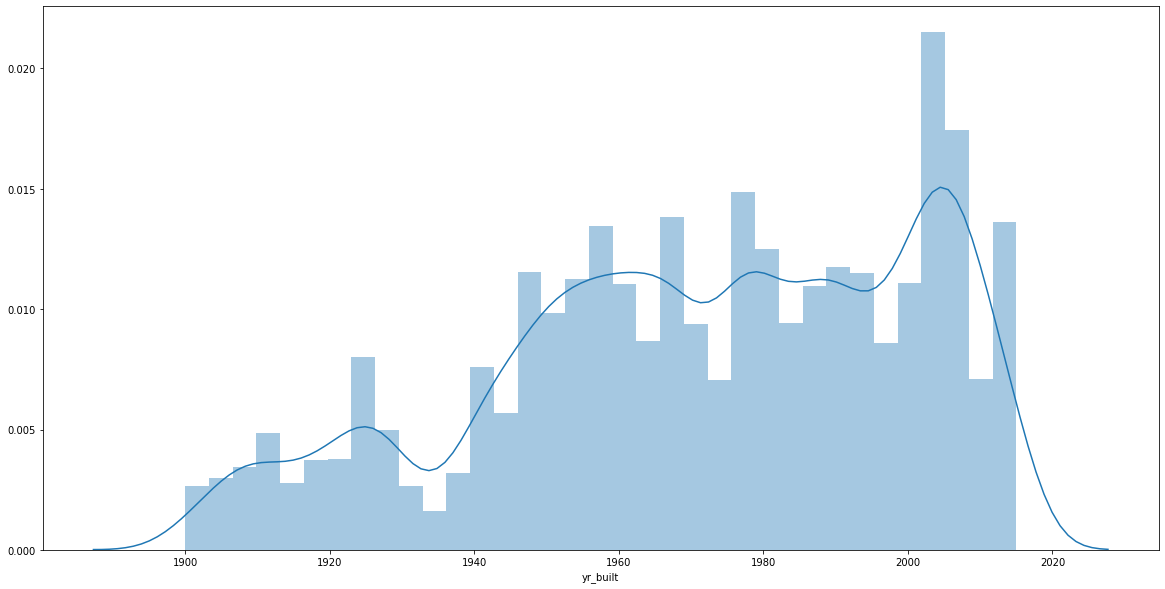

In [18]:
# Time to get into it
# - Identify a likely distribution for several of the features
plot_cols = ['bedrooms', 'price', 'bathrooms', 'sqft_living', 'yr_built']

for c in plot_cols:
    sns.distplot(housing[c])
    plt.show()


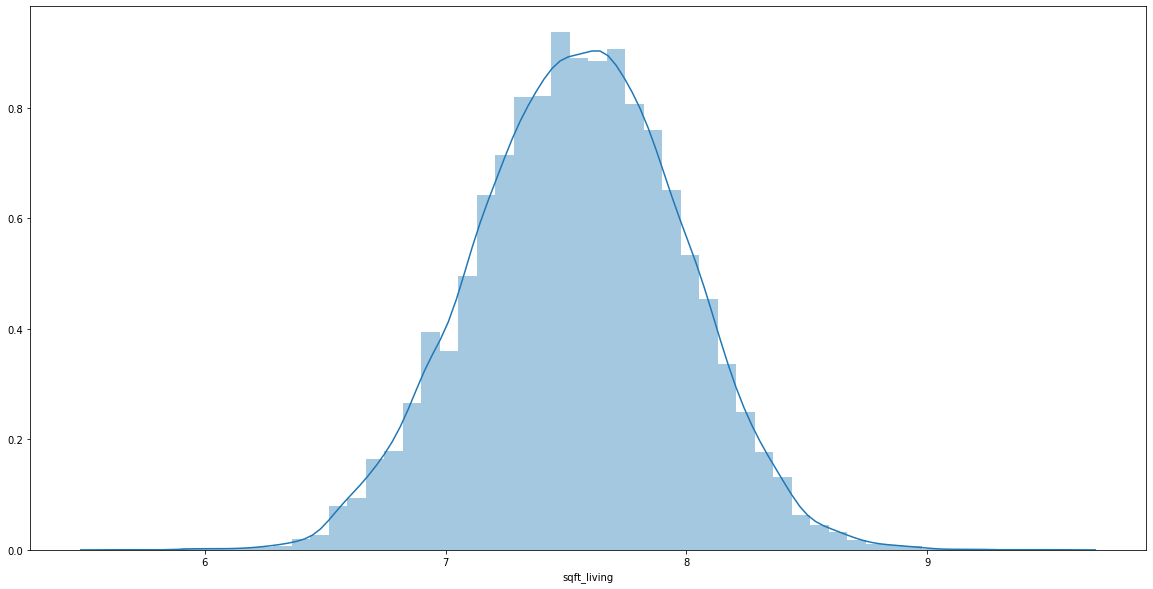

In [19]:
# Lets test some distributions!
# I think sqft_living is normal
sns.distplot(np.log(housing['sqft_living']));

# yeah, that's log normal.

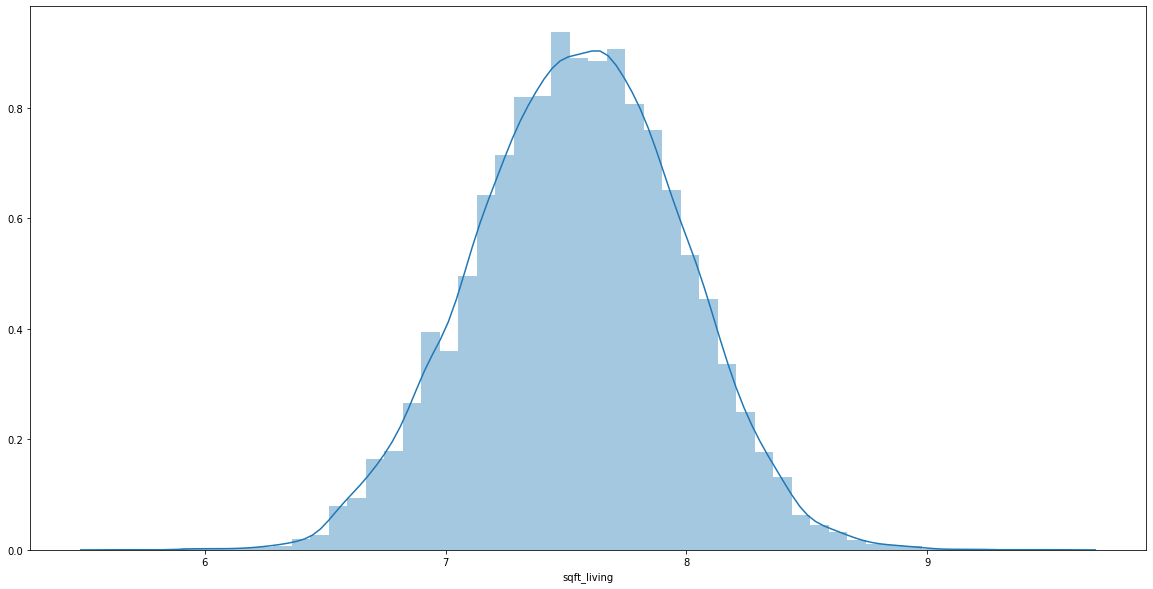

In [20]:
# How about price?
sns.distplot(np.log(housing['sqft_living']));

# also stupidly log normal.

# I'm adding a transformed column... hate messing with the np.log() stuff
housing['log_price'] = np.log(housing['price'])
housing['log_sqft_living'] = np.log(housing['sqft_living'])

### Compute basic summary statistics by both classical, bootstrap, and Bayesian methods

In [21]:
# Classical
print(f"Classical mean for price is {housing['price'].mean()}")

Classical mean for price is 540088.1417665294


Confidence interval using bootstrapping for price is between 540154.7530475797 and 540457.2796772618


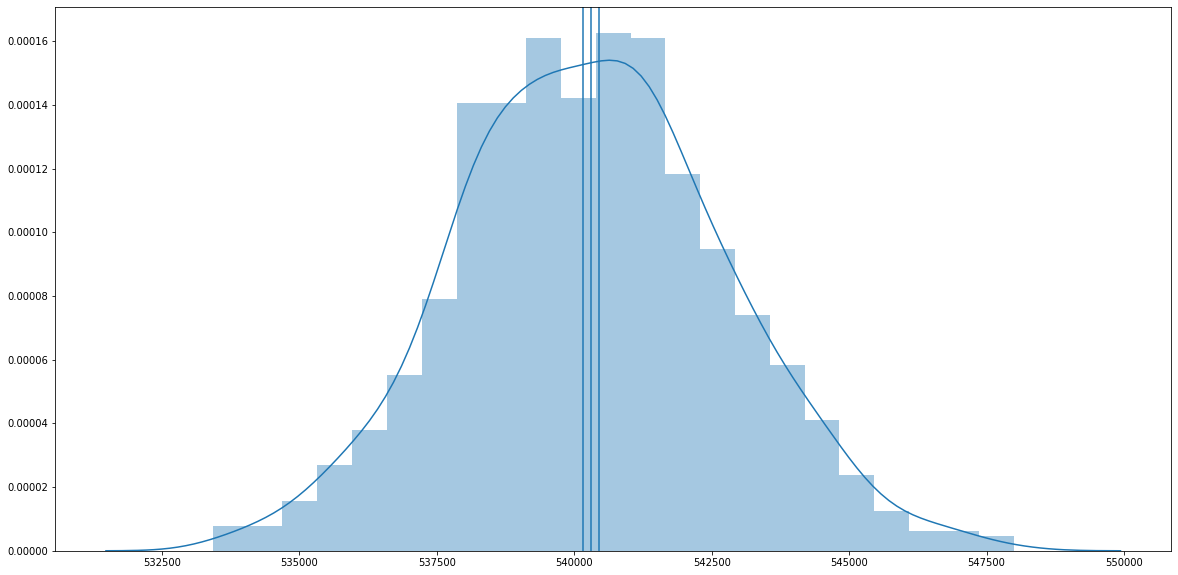

In [22]:
# Bootstrap
n_samples = 1000

# add in a nice plotting function with mean line
def plot_dist_mean(a, a_label):
    sns.distplot(a, label=a_label)
    plt.axvline(x=a.mean(), ymin=0, ymax=1)

bootstrap_means = pd.Series([    
    housing.sample(frac=1, replace=True)['price'].mean()
    for i in range(n_samples)])

bootstrap_ci_5, bootstrap_ci_95 = sms.DescrStatsW(bootstrap_means).tconfint_mean()

plot_dist_mean(bootstrap_means, 'Bootstrapped Mean with 5 and 95% CI');
plt.axvline(x=bootstrap_ci_5, ymin=0, ymax=1)
plt.axvline(x=bootstrap_ci_95, ymin=0, ymax=1)
print(f"Confidence interval using bootstrapping for price is between {bootstrap_ci_5} and {bootstrap_ci_95}")

In [24]:
price_df = housing['price']
price_df.describe(percentiles=[x/10 for x in range(1,10)]+[.95, .99, .995])

count     21613.00000
mean     540088.14177
std      367127.19648
min       75000.00000
10%      245000.00000
20%      298470.00000
30%      345000.00000
40%      399500.00000
50%      450000.00000
60%      519000.00000
70%      595000.00000
80%      700108.00000
90%      887000.00000
95%     1156480.00000
99%     1964400.00000
99.5%   2453290.00000
max     7700000.00000
Name: price, dtype: float64

In [25]:
# Bayesian
N = 10000
# We're going to use the 10th and 95 percentiles... outliers will mess with this.
x = np.linspace(start = 245000,
                stop = 1156480,
                num = N)

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


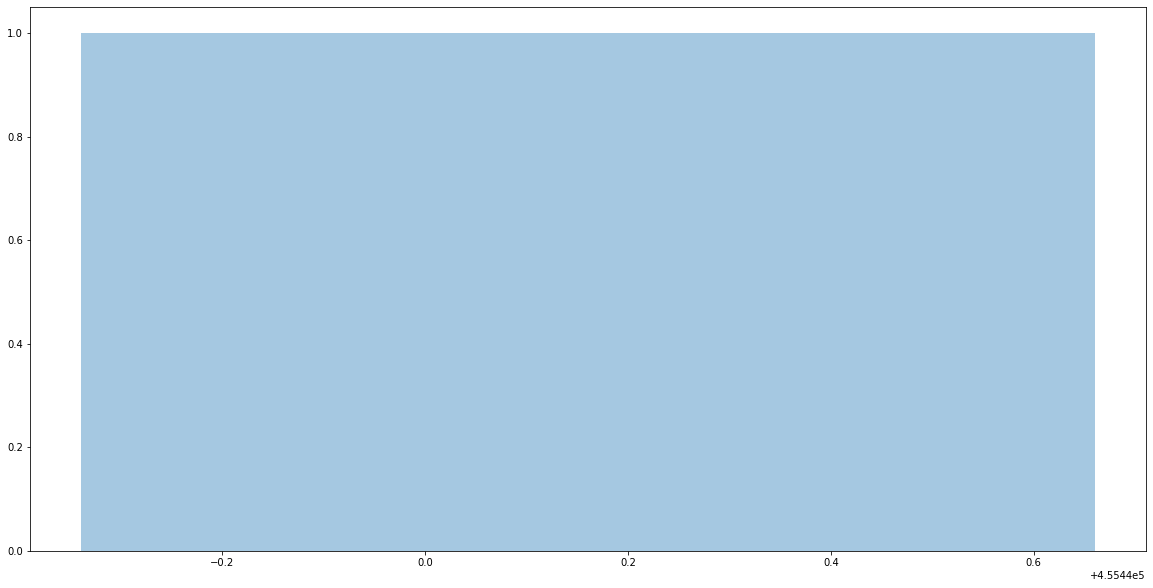

In [26]:
# I want to use a reasonably informed prior, so I'm chosing the 40% and 60% percentile
# This is to say that I believe the true population mean lies somewhere between the 40th and 60th percentile of the King county data set.
prior_price = np.random.uniform(low = housing['price'].quantile(.40), 
                                high = housing['price'].quantile(.60))

sns.distplot(prior_price);

In [27]:
# Now create a posterior estimate of the mean
price_sample = housing.sample(n=n_samples, replace=True)

def likelihood(p, x): 
    x_var = np.var(x) # sigmasqr
    x_mean = np.mean(x)  # xbar
    print(f'Bayesian mean = {x_mean:.3f}, standard deviation = {x_var:.3f}')
    n = len(x)
    l = np.exp((-1/(2*x_var)) * (sum((x - x_mean)**2) + n*(x_mean - p)**2))
    return l / l.sum()

def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

likelihood_price = likelihood(x, price_sample['price'])
posterior_price = posterior(prior_price, likelihood_price)

Bayesian mean = 528991.352, standard deviation = 130361169949.334


The  95% credible interval is 506347.451 to 551016.716


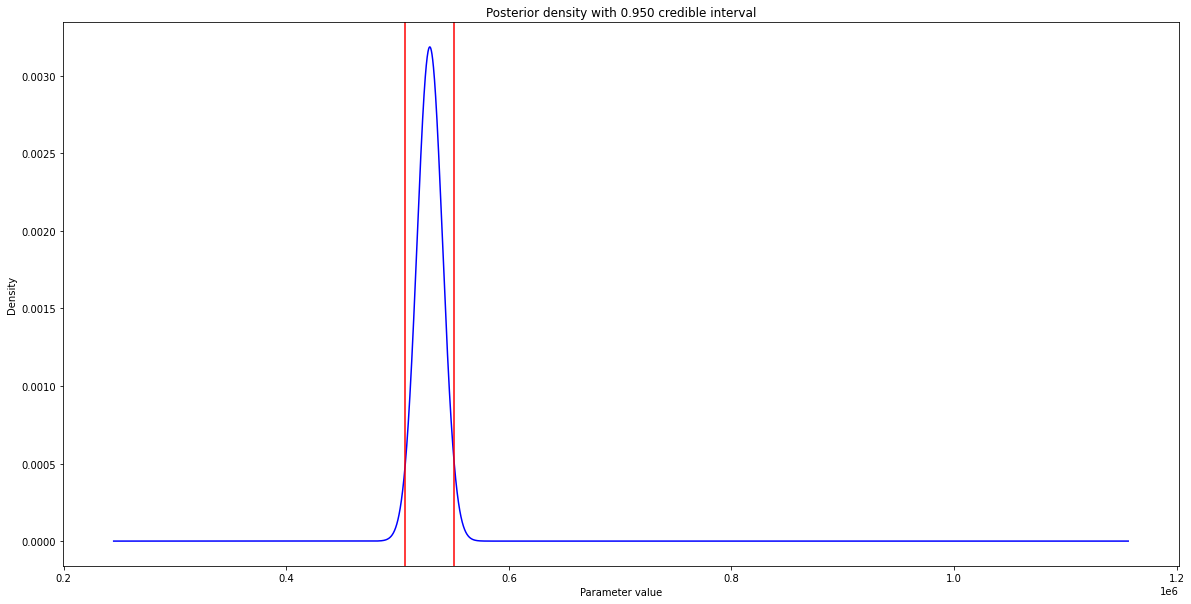

In [28]:
# let's plot the credible interval for the mean estimate
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(p, post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print(f'The {interval*100: 0.0f}% credible interval is {ci[0]:0.3f} to {ci[1]:0.3f}')
    
plot_ci(x, posterior_price, N, lower_q, upper_q)

In [29]:
# Leverage confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant.
from scipy.stats import ttest_ind

classical_mean = housing['price'].mean()
bootstrap_mean = bootstrap_means.mean()

ttest, pval = ttest_ind(bootstrap_means, posterior_price)
print("p-value", pval)

p-value 0.0


-----
# Milestone 3

Everything below this comment has been added for milestone 3.

## Project Guidance and Instructions
Milestone 3 allows you to apply the knowledge you gained in Unit 3 of the course. In this milestone, you need to prepare the data for modeling as well as build an initial model that you will need to refine for Milestone 4.

### For Milestone 3 you should

- Prepare the data via cleaning, normalization, encoding, etc.
- Generate and evaluate a working model (linear, or time series).

First off, let's talk about _what_ this model will be used for, since that's ultimately what's going to determine how we build it. This model will be used for a "median family" to look for a house they can afford. 

The problem statement for Milestone 1 was:  

    "A young family moving to King county would like to know how housing features contribute to the price of different houses. This may help them focus their search on houses within their price range."
    
This means a few things:
- Extreme values for price are probably not useful in any way. They will distort any value towards the center of these data.
- Any testing of the model's accuracy should take this into account - inaccurate model performance at the extreme values of these data literally doesn't matter for this model's problem statement. If we have a 300% error in a house costing $10 million USD, who cares?


With that in mind, let's jump into.... DATA CLEANING

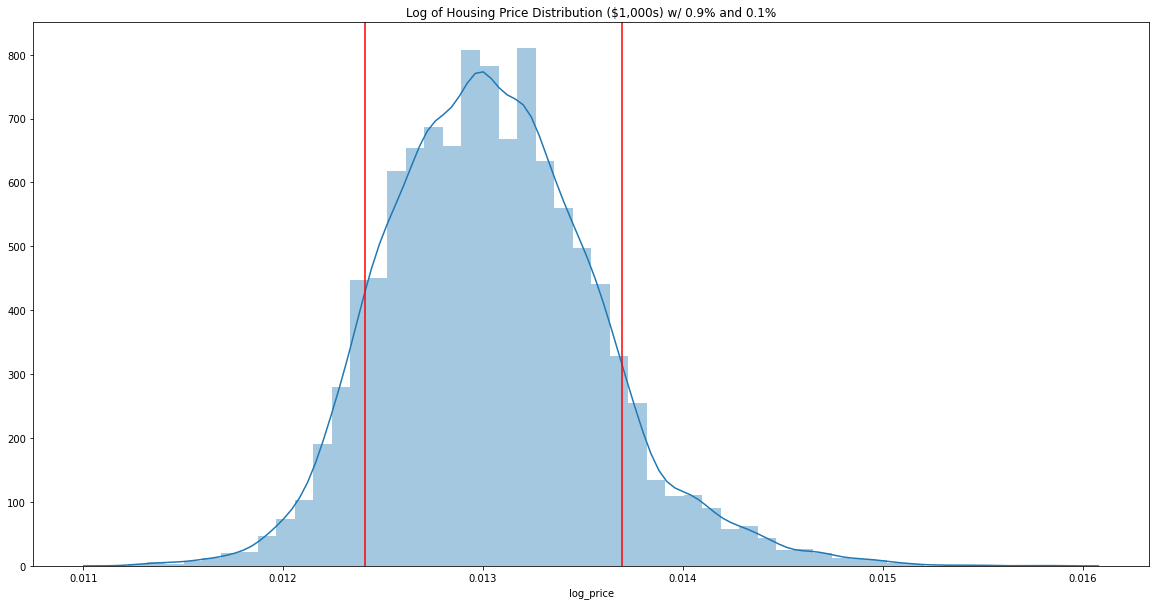

In [74]:
# First, let's get look at the extreme values:
high_ntile = .90
low_ntile = .10

sns.distplot(housing['log_price'] / 1000)
plt.title(f'Log of Housing Price Distribution ($1,000s) w/ {high_ntile}% and {low_ntile}%')
plt.axvline(housing['log_price'].quantile(high_ntile) / 1000, 0, 1, color = 'r')
plt.axvline(housing['log_price'].quantile(low_ntile) / 1000, 0, 1, color = 'r')
plt.show();

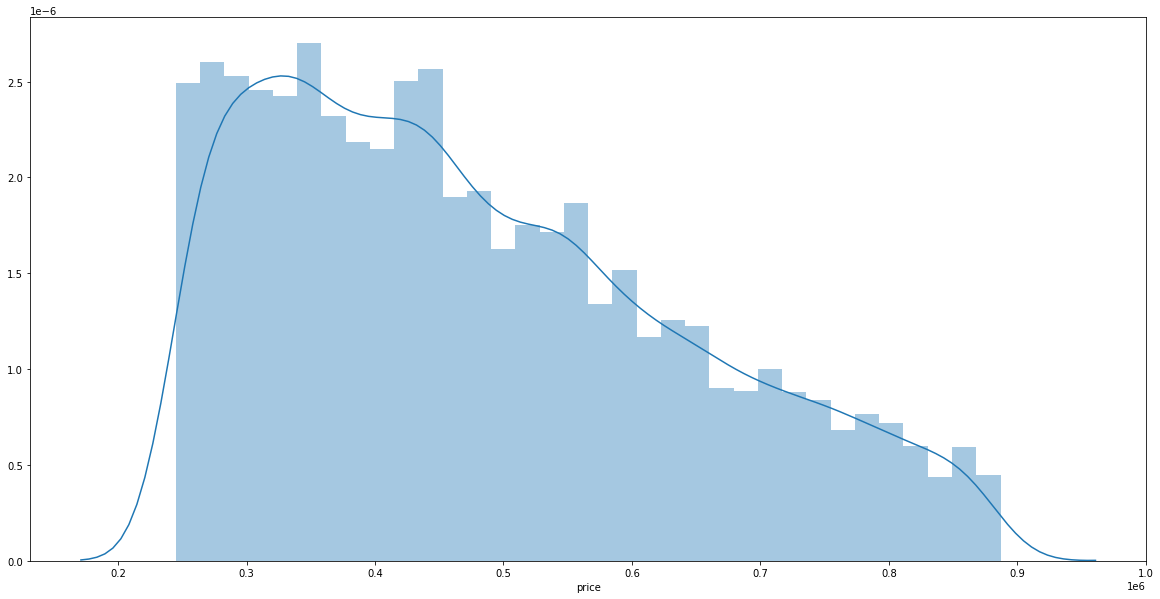

In [77]:
# looks like we could cut out anything above the 90% and below 7%
not_high_price = housing['log_price'] <= housing['log_price'].quantile(high_ntile)
not_low_price = housing['log_price'] >= housing['log_price'].quantile(low_ntile)

housing_clean = housing[not_high_price & not_low_price]
sns.distplot(housing_clean['price']);

In [80]:
# Let's look at the range of prices for houses now that we've removed extreme price values...
housing_clean['price'].describe(percentiles=[x/10 for x in range(1,10)]+[.95, .99, .995])

# cool - min $245,000, max $887,000.

count    17371.00000
mean    480613.90830
std     163994.16646
min     245000.00000
10%     285000.00000
20%     325000.00000
30%     364000.00000
40%     406500.00000
50%     450000.00000
60%     500000.00000
70%     559950.00000
80%     630100.00000
90%     730000.00000
95%     799000.00000
99%     865000.00000
99.5%   875000.00000
max     887000.00000
Name: price, dtype: float64

In [81]:
housing_clean.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'log_price',
       'log_sqft_living'],
      dtype='object')

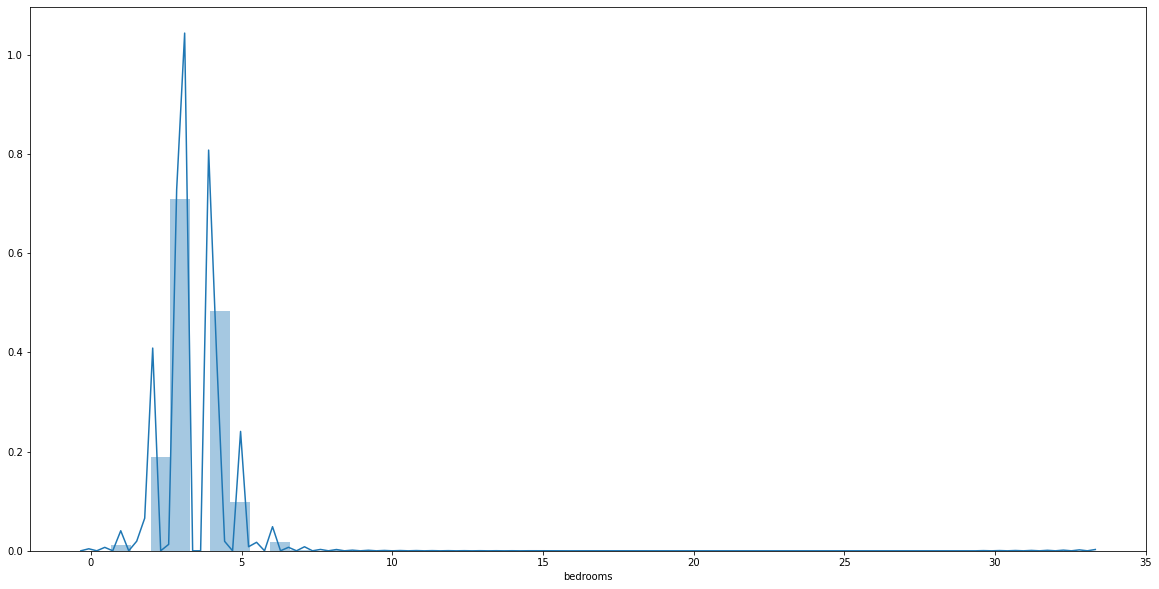

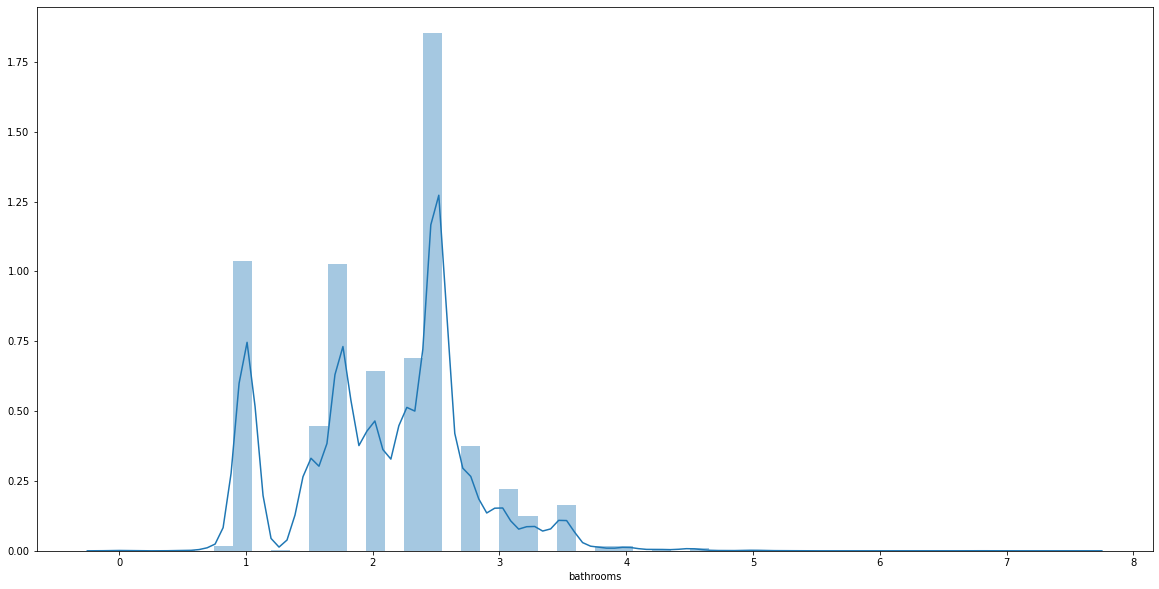

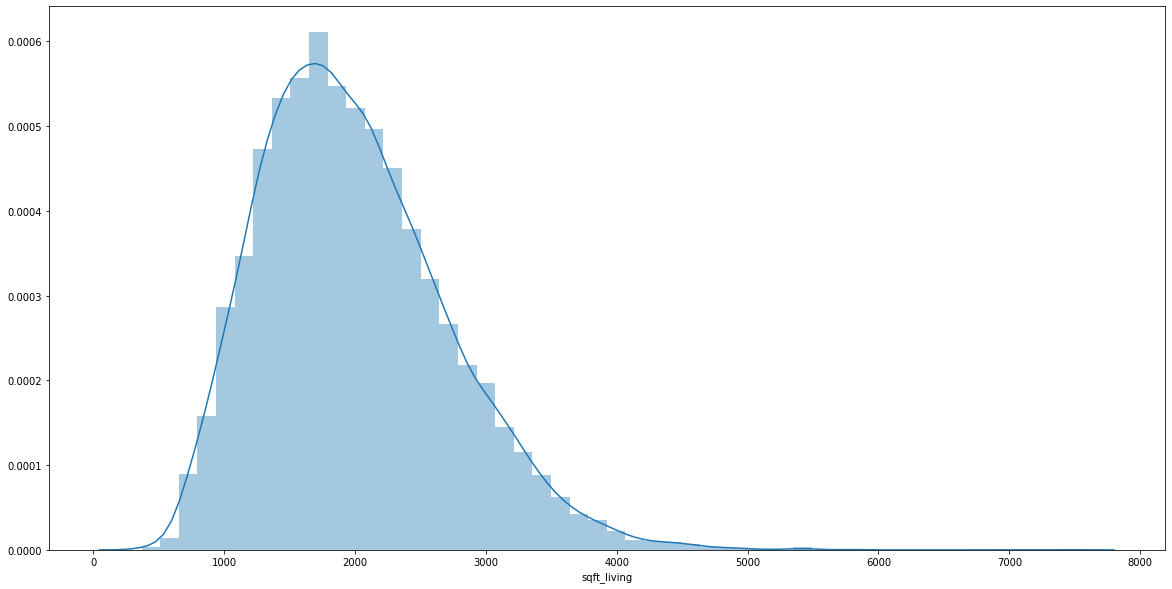

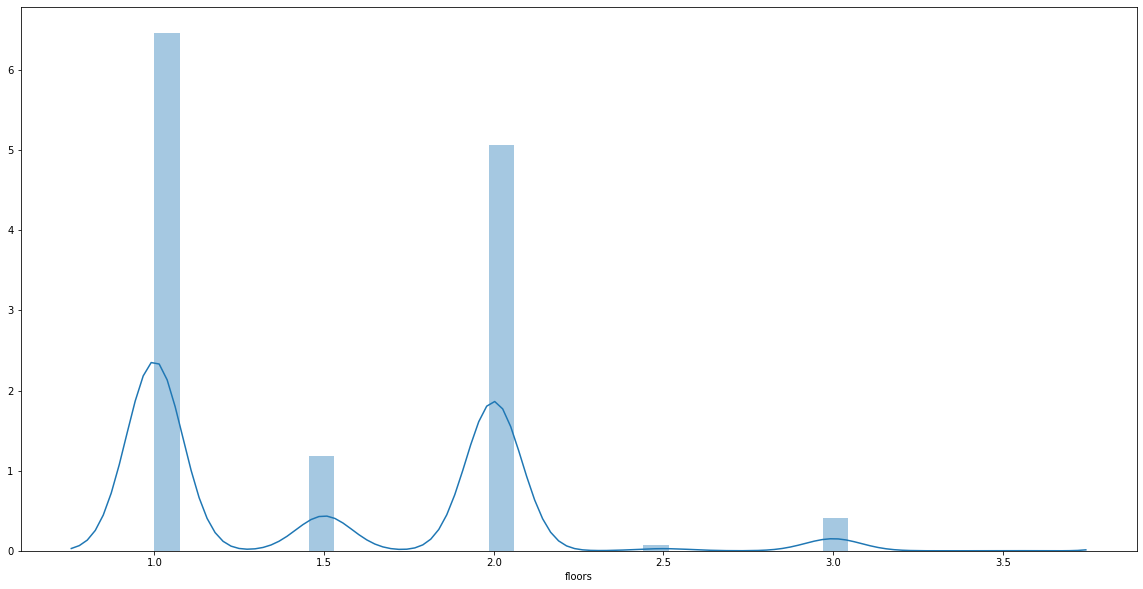

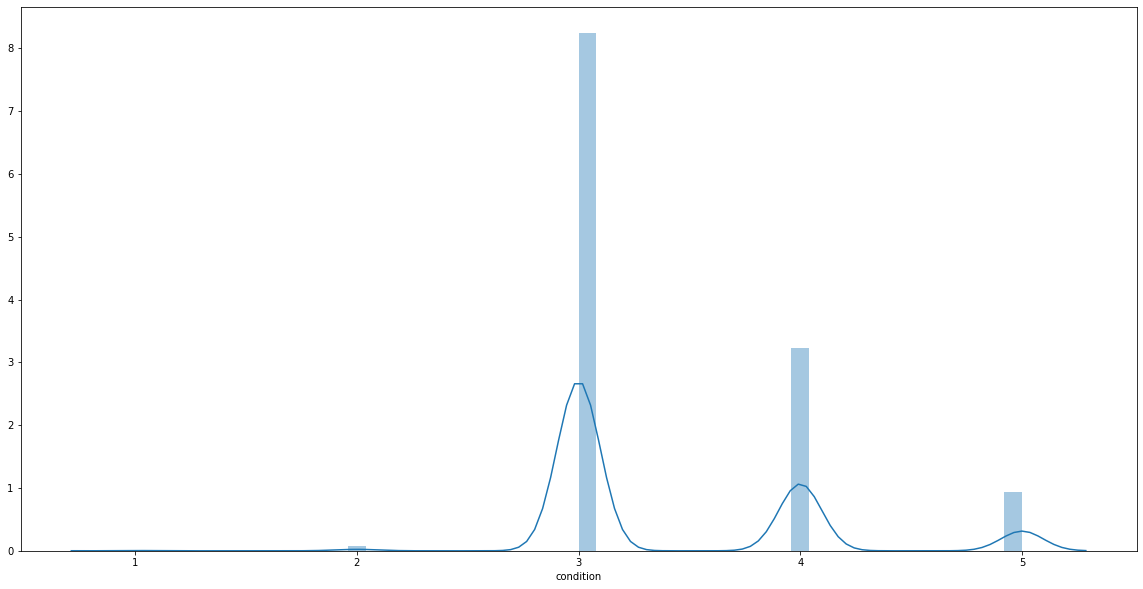

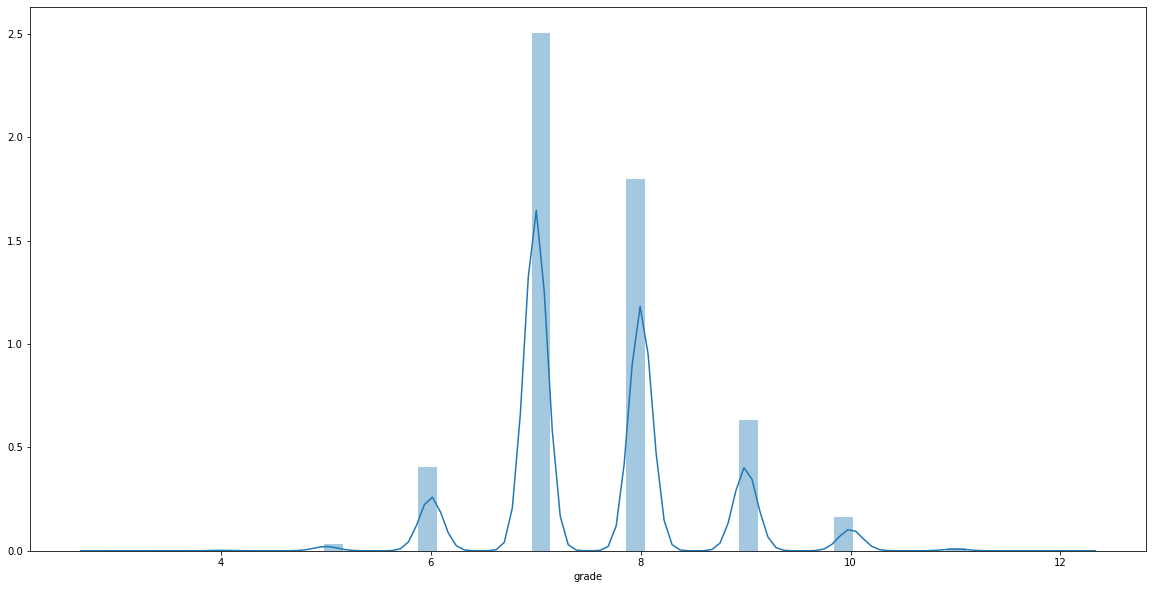

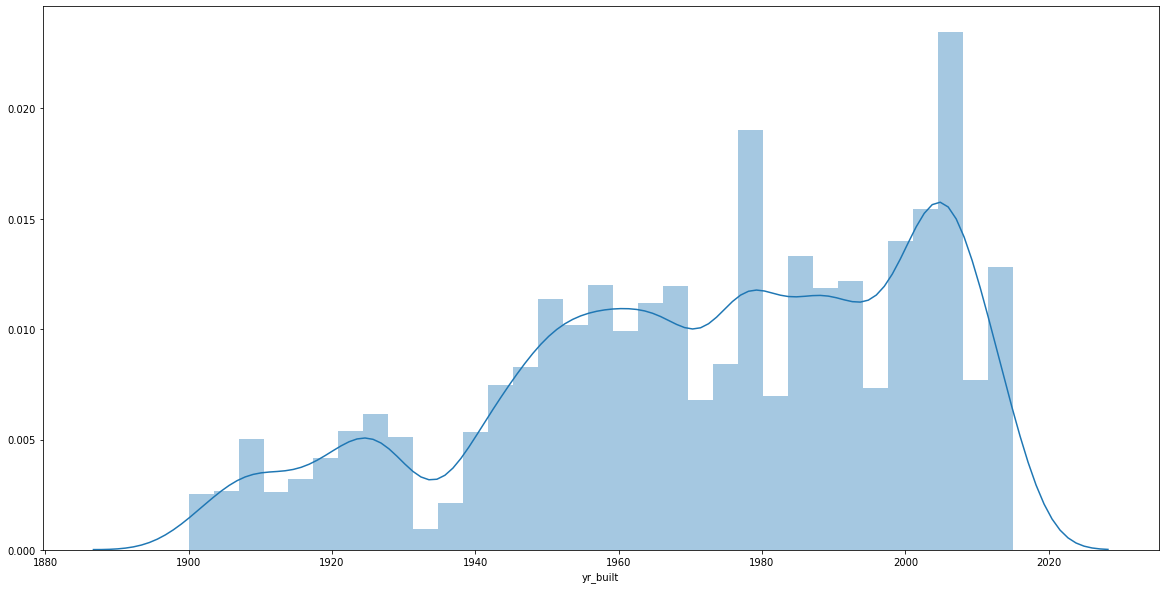

In [85]:
# Now let's look for other extreme values.
plot_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'condition',
            'grade', 'yr_built']

for c in plot_cols:
    sns.distplot(housing_clean[c])
    plt.show();

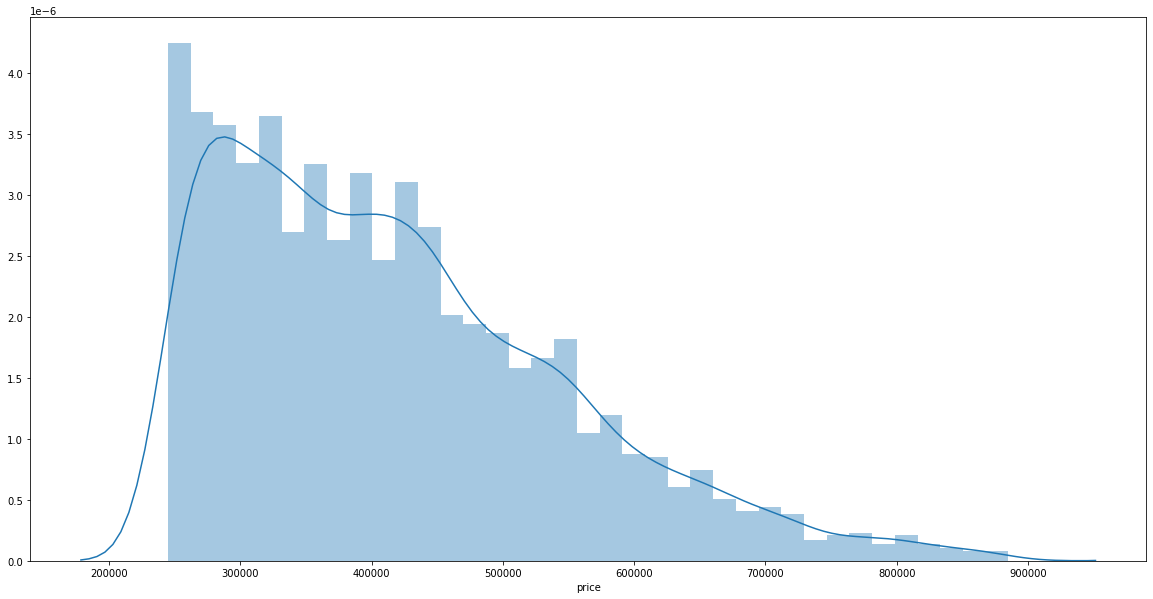

In [94]:
# we should probably clean out extreme values for:
# - bedrooms
# - sq ft living

# given that an "average" person doesn't live in a house with 10 bedrooms and 4,000 sq ft.

normal_bedrooms = housing_clean['bedrooms'] <= 6
normal_sqft = housing_clean['sqft_living'] <= housing_clean['sqft_living'].quantile(high_ntile)

housing_clean = housing_clean[normal_bedrooms & normal_sqft]

sns.distplot(housing_clean['price'])
plt.show()

In [95]:
housing_clean['price'].describe(percentiles=[x/10 for x in range(1,10)]+[.95, .99, .995])

count     9301.00000
mean    417080.63585
std     129752.02960
min     245000.00000
10%     269950.00000
20%     297500.00000
30%     325000.00000
40%     358000.00000
50%     395000.00000
60%     430000.00000
70%     469000.00000
80%     525000.00000
90%     600000.00000
95%     669000.00000
99%     800000.00000
99.5%   830000.00000
max     885000.00000
Name: price, dtype: float64

In [102]:
# Let's make a model
# We now have "average" houses, so let's make a model that will predict the price of any new house. 
# We'll split into a test/train/validate so we can look at accuracy
import statsmodels.formula.api as smf 

house_train, house_validate, house_test = np.split(housing_clean.sample(frac=1), [int(.6*len(housing_clean)), int(.8*len(housing_clean))])

# potential columns for modeling:
#['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
#       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
#       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
#       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'log_price',
#       'log_sqft_living']

# I'm going to be quite careful which columns to include in any model, as some of them are going to be highly multi-colinear,
# while others don't make sense to include (date, ID)

# Let's start with linear regression...
naive_model_formula = "price ~ sqft_lot + sqft_living + bedrooms + bathrooms + C(view) + condition + grade + yr_built"
naive_reg_model = smf.ols(data = house_train, formula = naive_model_formula).fit()

naive_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     133.2
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:09:20   Log-Likelihood:                -72614.
No. Observations:                5580   AIC:                         1.453e+05
Df Residuals:                    5560   BIC:                         1.454e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.165e+06   1.17e+05     35.661      0.000    3.94e+06    4.39e+06
C(view)[T.1]    2.814e+04   1.47e+04      1.921      0.055    -583.214    5.69e+04
C(view)[T.2]    3.202e+04   9104.728      3.517      0.000    1.42e+04    4.99e+04
C(view)[T.3]    2.867e+04   1.62e+04      1.772      0.076   -3041.356    6.04e+04
C(view)[T.4]    1.491e+05   2.13e+04      7.006      0.000    1.07e+05    1.91e+05
condition[T.2] -3.762e+04   3.86e+04     -0.975      0.330   -1.13e+05     3.8e+04
condition[T.3] -1588.2948    3.5e+04     -0.045      0.964   -7.02e+04    6.71e+04
condition[T.4] -8147.3284    3.5e+04     -0.233      0.816   -7.68e+04    6.05e+04
condition[T.5]  1.463e+04   3.53e+04      0.414      0.679   -5.46e+04    8.38e+04
grade[T.3]      9.642e-10   3.08e-11     31.293      0.000    9.04e-10    1.02e-09
grade[T.4]      4.504e+05   3.99e+04     11.290      0.000    3.72e+05    5.29e+05
grade[T.5]      4.456e+05    2.1e+04     21.245      0.000    4.04e+05    4.87e+05
grade[T.6]      4.618e+05   1.75e+04     26.457      0.000    4.28e+05    4.96e+05
grade[T.7]      5.458e+05   1.82e+04     30.064      0.000     5.1e+05    5.81e+05
grade[T.8]      6.416e+05    1.9e+04     33.842      0.000    6.04e+05    6.79e+05
grade[T.9]       7.78e+05   2.13e+04     36.449      0.000    7.36e+05     8.2e+05
grade[T.10]     8.421e+05   3.58e+04     23.509      0.000    7.72e+05    9.12e+05
grade[T.11]     4.175e-11   4.14e-12     10.080      0.000    3.36e-11    4.99e-11
grade[T.12]    -4.381e-11   3.73e-12    -11.743      0.000   -5.11e-11   -3.65e-11
grade[T.13]    -2.159e-11   6.61e-12     -3.267      0.001   -3.45e-11   -8.63e-12
sqft_lot           0.1193      0.042      2.852      0.004       0.037       0.201
sqft_living       52.0570      6.305      8.256      0.000      39.696      64.418
bedrooms        -1.46e+04   2446.535     -5.969      0.000   -1.94e+04   -9807.284
bathrooms       2.387e+04   3570.665      6.685      0.000    1.69e+04    3.09e+04
yr_built       -2231.9313     66.542    -33.542      0.000   -2362.380   -2101.482
==============================================================================
Omnibus:                      368.838   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              478.295
Skew:                           0.608   Prob(JB):                    1.38e-104
Kurtosis:                       3.762   Cond. No.                     4.83e+23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.33e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Naive Model Summary

So this model is... not great. R squared of .31 which means it explains (on average) 31% of the variance in price.
That doesn't mean that this model is useless though... it shows a few things:
- condition doesn't need to be included, as it has not significant p-values
- view matters!
- there's multi-colinearity (probably... it's in the warnings)
- sqft_lot is bordering on not important (indicated by a low p-value). Given the multi-colinearity, I will chose to drop it.

In [110]:
# Let's change the regression formula to include different information.

linear_model_2_formula = (f"price ~ bedrooms + bathrooms + sqft_living + floors + waterfront" 
                         f"+ C(grade) + C(view) + yr_built + yr_renovated + sqft_above + C(zipcode) + lat + long"
                         f"+ sqft_living15 + sqft_lot15")  
    
lm2_reg_model = smf.ols(data = house_train, formula = linear_model_2_formula).fit()

lm2_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     150.3
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:17:47   Log-Likelihood:                -70171.
No. Observations:                5580   AIC:                         1.405e+05
Df Residuals:                    5488   BIC:                         1.411e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.279e+07   5.98e+06     -2.138      0.033   -2.45e+07   -1.06e+06
waterfront[T.1]      1.397e+05   2.22e+04      6.308      0.000    9.63e+04    1.83e+05
C(grade)[T.3]           0.0001    5.2e-05      2.139      0.032    9.29e-06       0.000
C(grade)[T.4]       -1.835e+06   8.55e+05     -2.147      0.032   -3.51e+06    -1.6e+05
C(grade)[T.5]       -1.897e+06   8.55e+05     -2.220      0.026   -3.57e+06   -2.22e+05
C(grade)[T.6]       -1.899e+06   8.55e+05     -2.222      0.026   -3.57e+06   -2.24e+05
C(grade)[T.7]       -1.866e+06   8.55e+05     -2.183      0.029   -3.54e+06   -1.91e+05
C(grade)[T.8]       -1.828e+06   8.55e+05     -2.139      0.032    -3.5e+06   -1.52e+05
C(grade)[T.9]       -1.756e+06   8.55e+05     -2.054      0.040   -3.43e+06   -8.01e+04
C(grade)[T.10]      -1.709e+06   8.55e+05     -1.997      0.046   -3.39e+06   -3.17e+04
C(grade)[T.11]       8.405e-07   3.92e-07      2.142      0.032    7.14e-08    1.61e-06
C(grade)[T.12]      -1.788e-07   8.39e-08     -2.132      0.033   -3.43e-07   -1.44e-08
C(grade)[T.13]      -1.962e-06   9.18e-07     -2.138      0.033   -3.76e-06   -1.63e-07
C(view)[T.1]         2.941e+04   9743.173      3.019      0.003    1.03e+04    4.85e+04
C(view)[T.2]         4.305e+04   6081.081      7.079      0.000    3.11e+04     5.5e+04
C(view)[T.3]         4.214e+04   1.09e+04      3.873      0.000    2.08e+04    6.35e+04
C(view)[T.4]         1.159e+05   1.78e+04      6.516      0.000     8.1e+04    1.51e+05
C(zipcode)[T.98002]  2.015e+04    1.8e+04      1.119      0.263   -1.51e+04    5.54e+04
C(zipcode)[T.98003] -1.061e+04    1.4e+04     -0.757      0.449   -3.81e+04    1.69e+04
C(zipcode)[T.98004]  4.554e+05    2.4e+04     18.960      0.000    4.08e+05    5.03e+05
C(zipcode)[T.98005]  2.846e+05   2.51e+04     11.328      0.000    2.35e+05    3.34e+05
C(zipcode)[T.98006]  1.972e+05   2.14e+04      9.220      0.000    1.55e+05    2.39e+05
C(zipcode)[T.98007]  2.294e+05   2.41e+04      9.504      0.000    1.82e+05    2.77e+05
C(zipcode)[T.98008]  2.283e+05   2.42e+04      9.445      0.000    1.81e+05    2.76e+05
C(zipcode)[T.98010]  1.382e+05   2.33e+04      5.932      0.000    9.25e+04    1.84e+05
C(zipcode)[T.98011]  1.437e+05   3.09e+04      4.651      0.000    8.31e+04    2.04e+05
C(zipcode)[T.98014]  1.705e+05   3.39e+04      5.027      0.000    1.04e+05    2.37e+05
C(zipcode)[T.98019]  1.333e+05   3.42e+04      3.899      0.000    6.63e+04       2e+05
C(zipcode)[T.98022]  4.504e+04   2.06e+04      2.190      0.029    4721.213    8.53e+04
C(zipcode)[T.98023] -3.781e+04    1.4e+04     -2.702      0.007   -6.52e+04   -1.04e+04
C(zipcode)[T.98024]  1.617e+05    3.1e+04      5.222      0.000    1.01e+05    2.22e+05
C(zipcode)[T.98027]  1.861e+05   2.21e+04      8.409      0.000    1.43e+05    2.29e+05
C(z

## Model summary

### Why did this improve so much?
We're including the most important thing in real estate - location. There's signal about geography now (ZIP code), as well as neighborhood data (the sqft_living15 and sqft_lot15 columns, which include neighboring house sales.

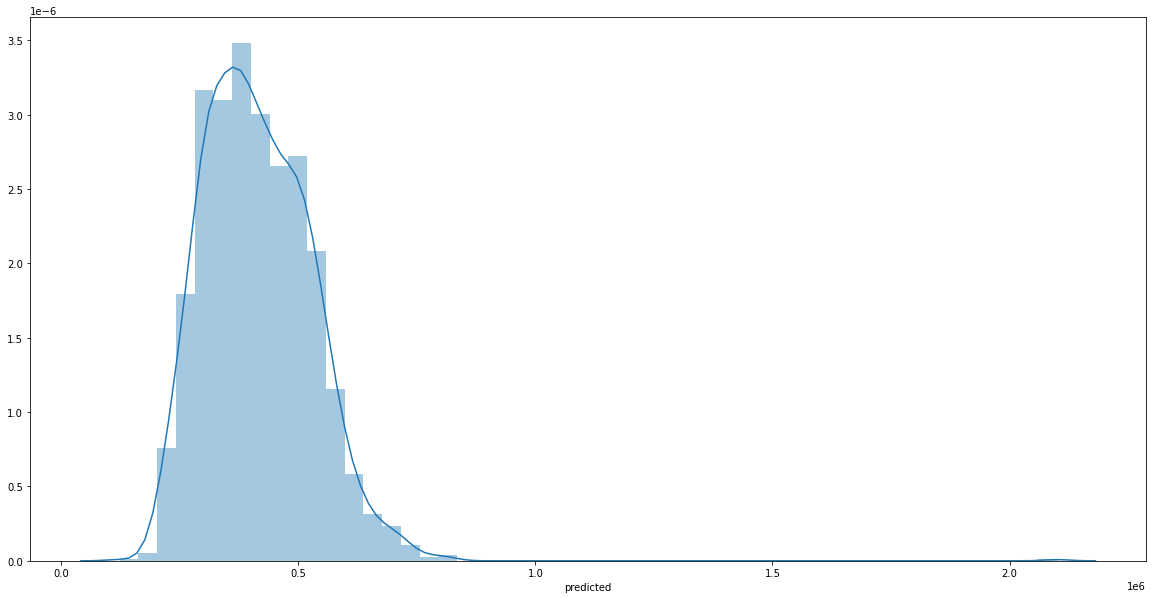

In [114]:
# Test performance on the test data...
X_test = house_test.loc[:, house_test.columns != 'price']
Y_test = house_test['price']

# Now let's predict the prices for the test data set
house_test['predicted'] = lm2_reg_model.predict(X_test)

# and plot the residuals to make sure they're roughly normally distributed.
sns.distplot(house_test['predicted']);